In [1]:
%load_ext autoreload
%autoreload

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import prim
import seaborn as sns
from sklearn import mixture
import os
from clustering_and_prim_tools import *
from SALib.analyze import sobol
from SALib.sample import saltelli

In [3]:
%matplotlib inline

In [4]:
sns.set_context("poster",rc={"font.size": 28})
sns.set_style("whitegrid")

In [5]:
invfolder = "C:\\Users\\WB451855\OneDrive - WBG\\!infra_needs_data\\transport_cired_output_data\\outputs_investments_module_billionusd/"
imaclimfolder = "C:/Users/WB451855/OneDrive - WBG/!infra_needs_data/transport_cired_output_data/outputs_Imaclim/"
physicalinfrafolder = "C:/Users/WB451855/OneDrive - WBG/!infra_needs_data/transport_cired_output_data/outputs_investments_module_physical_stock/"

# First I look at the results from the Imaclim model only (output = transport activity but no investment need)

In [6]:
os.listdir(imaclimfolder)

['results_transports_Imaclim_ASIA.csv',
 'results_transports_Imaclim_CIS.csv',
 'results_transports_Imaclim_LAM.csv',
 'results_transports_Imaclim_MAF.csv',
 'results_transports_Imaclim_OCDE.csv',
 'results_transports_Imaclim_WORLD.csv']

In [7]:
pd.options.display.max_seq_items = 2000

In [8]:
all_ima_data = pd.DataFrame()
for myfilename in os.listdir(imaclimfolder):
    if "WORLD" in myfilename:
        continue
    myfile = pd.read_csv(imaclimfolder+"\\"+myfilename,sep=";")
    myinfo = myfilename.replace(".csv",'').split("_")
    myfile["region"] = myinfo[3]
    all_ima_data = all_ima_data.append(myfile)

In [9]:
all_ima_data.Variable.unique()

array(['Population', 'CO2_em_tot', 'CO2_em_trans', 'PIB',
       'passenger_activity', 'freight_activity', 'pkm_OT', 'pkm_auto',
       'pkm_air', 'fret_air', 'fret_OT', 'fret_mer'], dtype=object)

In [10]:
indexes_ima = ['//combi', 'ind_climat', 'ind_growth', 'ind_mitig', 'ind_trans_A',
       'ind_trans_S', 'ind_trans_I', 'ind_trans_F', 'ind_taxexo', 'ind_recycl',
       'ind_taxmax', 'Variable', 'Unit','region']

In [11]:
indexes_ima2 = ['ind_climat', 'ind_growth', 'ind_mitig', 'ind_trans_A',
       'ind_trans_S', 'ind_trans_I', 'ind_trans_F', 'ind_taxexo', 'ind_recycl',
       'ind_taxmax', 'Variable','region','year']

In [12]:
all_ima_data = all_ima_data.set_index(indexes_ima)
all_ima_data.columns.name='year'
all_ima_data = all_ima_data.drop(['2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014','2050', '2051', '2052', '2053', '2054', '2055', '2056', '2057', '2058',
       '2059', '2060', '2061', '2062', '2063', '2064', '2065', '2066', '2067',
       '2068', '2069', '2070', '2071', '2072', '2073', '2074', '2075', '2076',
       '2077', '2078', '2079', '2080', '2081', '2082', '2083', '2084', '2085',
       '2086', '2087', '2088', '2089', '2090', '2091', '2092', '2093', '2094',
       '2095', '2096', '2097', '2098', '2099'],axis=1)
all_ima_data = all_ima_data.stack('year')
all_ima_data.name = 'value'

In [13]:
out = all_ima_data.reset_index().drop(['Unit','//combi'],axis=1).set_index(indexes_ima2).unstack('Variable').value

In [14]:
out.columns

Index(['CO2_em_tot', 'CO2_em_trans', 'PIB', 'Population', 'freight_activity',
       'fret_OT', 'fret_air', 'fret_mer', 'passenger_activity', 'pkm_OT',
       'pkm_air', 'pkm_auto'],
      dtype='object', name='Variable')

## Data vizualisation for freight and passenger activity

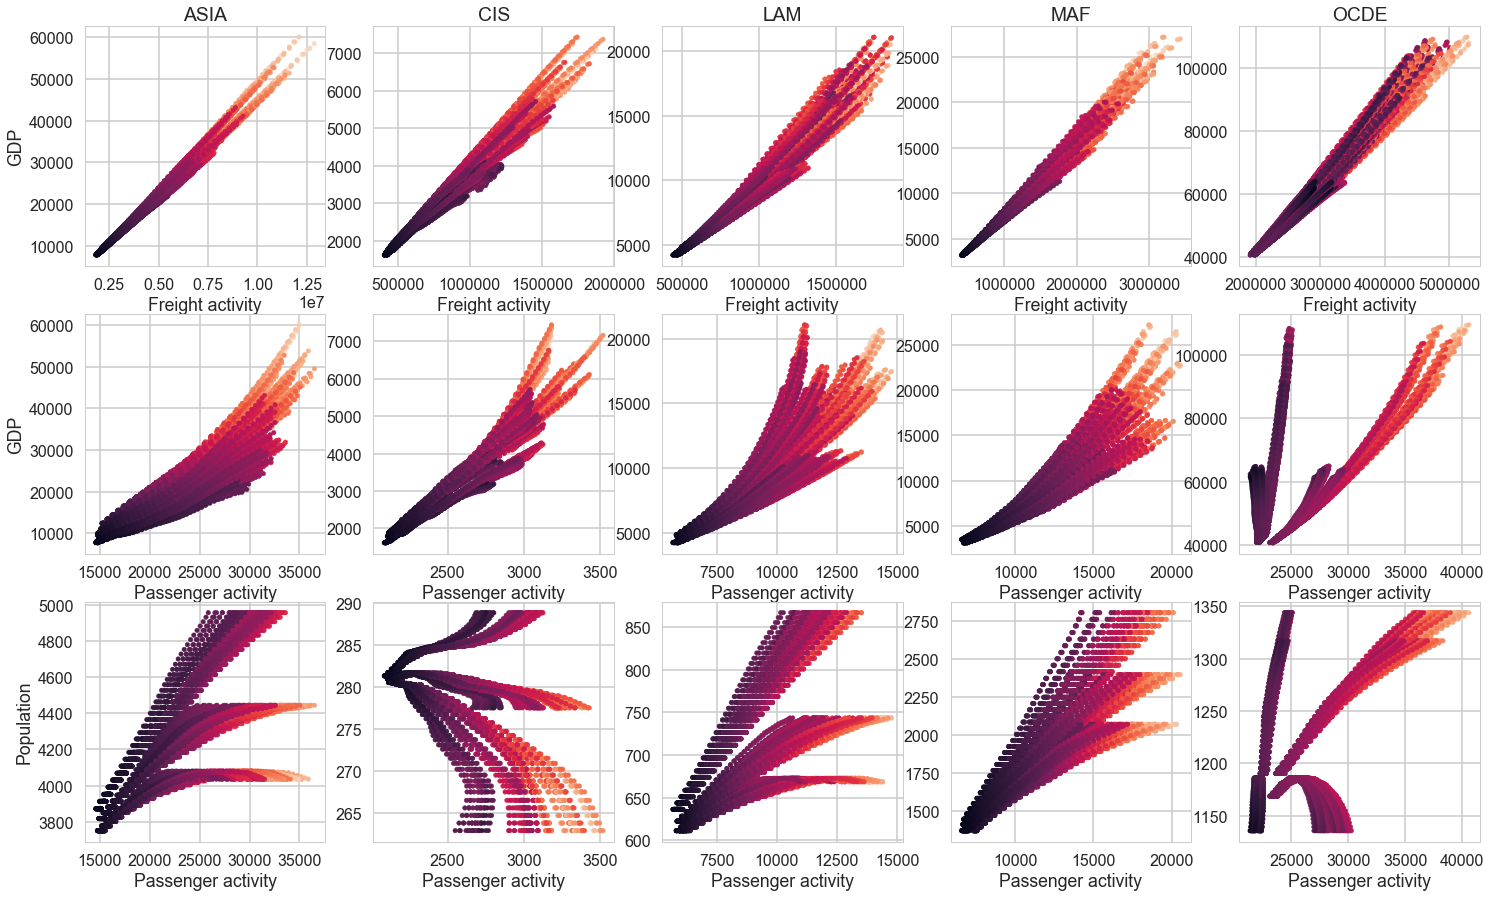

In [15]:
i=1
plt.figure(figsize=(25,15))
for reg,subframe in out.groupby(level='region'):
    plt.subplot(3,5,i)
    plt.scatter(subframe.freight_activity,subframe.PIB,c=subframe.CO2_em_trans,s=20)
    plt.title(reg)
    plt.xlabel("Freight activity")
    if i==1:
        plt.ylabel("GDP")
    i=i+1
    
for reg,subframe in out.groupby(level='region'):
    plt.subplot(3,5,i)
    plt.scatter(subframe.passenger_activity,subframe.PIB,c=subframe.CO2_em_trans,s=20)
    #plt.title(reg)
    plt.xlabel("Passenger activity")
    if i==6:
        plt.ylabel("GDP")
    i=i+1
    
for reg,subframe in out.groupby(level='region'):
    plt.subplot(3,5,i)
    plt.scatter(subframe.passenger_activity,subframe.Population,c=subframe.CO2_em_trans,s=20)
    #plt.title(reg)
    plt.xlabel("Passenger activity")
    if i==11:
        plt.ylabel("Population")
    i=i+1

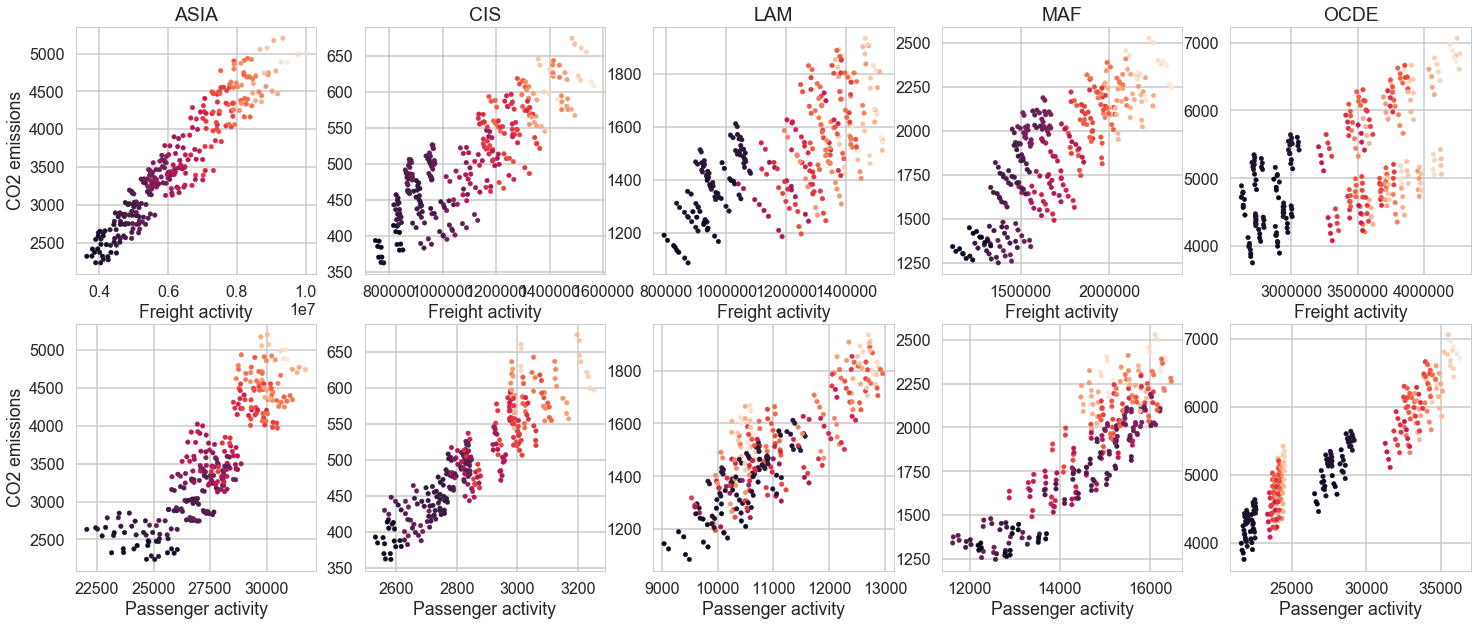

In [16]:
test = out.stack().unstack('year')['2040'].unstack('Variable')
i=1
plt.figure(figsize=(25,10))
for reg,subframe in test.groupby(level='region'):
    plt.subplot(2,5,i)
    plt.scatter(subframe.freight_activity,subframe.CO2_em_trans,c=subframe.PIB,s=20)
    plt.title(reg)
    plt.xlabel("Freight activity")
    if i==1:
        plt.ylabel("CO2 emissions")
    i=i+1
    
for reg,subframe in test.groupby(level='region'):
    plt.subplot(2,5,i)
    plt.scatter(subframe.passenger_activity,subframe.CO2_em_trans,c=subframe.PIB,s=20)
    plt.xlabel("Passenger activity")
    if i==6:
        plt.ylabel("CO2 emissions")
    #plt.title(reg)
    i=i+1

## Analysis of variance

In [28]:
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols

In [29]:
def drivers_from_anova(varin,mydata):
    formula=varin+" ~ ind_climat+ind_growth+ind_mitig+ind_trans_A+ind_trans_S+ind_trans_I+ind_trans_F"
    olsmodel=ols(formula,data=mydata).fit()
    table=anova_lm(olsmodel)
    table['sum_sq_pc']=table['sum_sq']/table['sum_sq'].sum()
    table=table.sort_values(by=['sum_sq'],ascending=False)
    sumvar=0
    drivers=list()
    for var in table.index:
        if var!='Residual':
            drivers.append(var)
            sumvar+=table.loc[var,'sum_sq_pc']
        if len(drivers)==3:
            break
    return drivers,sumvar

In [39]:
test = out.stack().unstack('year')['2040'].unstack('Variable')

for reg,subframe in test.groupby(level='region'):
    drivers,sumvar = drivers_from_anova("freight_activity",subframe.reset_index())
    print(reg,drivers,sumvar)

ASIA ['ind_climat', 'ind_growth', 'ind_mitig'] 0.809600941775
CIS ['ind_growth', 'ind_climat', 'ind_trans_A'] 0.880509889341
LAM ['ind_growth', 'ind_climat', 'ind_trans_A'] 0.877322200566
MAF ['ind_climat', 'ind_growth', 'ind_mitig'] 0.844568944681
OCDE ['ind_growth', 'ind_trans_A', 'ind_climat'] 0.942191786704


C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1814: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [60]:
test = out.stack().unstack('year')['2040'].unstack('Variable')

test = test.reset_index()
means = test.ix[test.region=="ASIA",:].set_index(['ind_climat', 'ind_growth', 'ind_mitig']).freight_activity.mean(level=['ind_climat', 'ind_growth', 'ind_mitig'])
print(means[means==means.max()])
print(means[means==means.min()])
print(means.min()/means.max()-1)

ind_climat  ind_growth  ind_mitig
0           1           2            8907375.0
Name: freight_activity, dtype: float64
ind_climat  ind_growth  ind_mitig
4           3           1            4045781.25
Name: freight_activity, dtype: float64
-0.545794215468


In [61]:
test = out.stack().unstack('year')['2040'].unstack('Variable')

test = test.reset_index()
means = test.ix[test.region=="CIS",:].set_index(['ind_growth', 'ind_climat', 'ind_trans_A']).freight_activity.mean(level=['ind_growth', 'ind_climat', 'ind_trans_A'])
print(means[means==means.max()])
print(means[means==means.min()])
print(means.min()/means.max()-1)

ind_growth  ind_climat  ind_trans_A
1           0           1              1481125.0
Name: freight_activity, dtype: float64
ind_growth  ind_climat  ind_trans_A
3           4           2              798968.75
Name: freight_activity, dtype: float64
-0.460566292514


In [62]:
test = out.stack().unstack('year')['2040'].unstack('Variable')

test = test.reset_index()
means = test.ix[test.region=="LAM",:].set_index(['ind_growth', 'ind_climat', 'ind_trans_A']).freight_activity.mean(level=['ind_growth', 'ind_climat', 'ind_trans_A'])
print(means[means==means.max()])
print(means[means==means.min()])
print(means.min()/means.max()-1)

ind_growth  ind_climat  ind_trans_A
1           0           1              1497675.0
Name: freight_activity, dtype: float64
ind_growth  ind_climat  ind_trans_A
3           4           2              853506.25
Name: freight_activity, dtype: float64
-0.43011250772


In [63]:
test = out.stack().unstack('year')['2040'].unstack('Variable')

test = test.reset_index()
means = test.ix[test.region=="MAF",:].set_index(['ind_climat', 'ind_growth', 'ind_mitig']).freight_activity.mean(level=['ind_climat', 'ind_growth', 'ind_mitig'])
print(means[means==means.max()])
print(means[means==means.min()])
print(means.min()/means.max()-1)

ind_climat  ind_growth  ind_mitig
0           1           2            2227431.25
Name: freight_activity, dtype: float64
ind_climat  ind_growth  ind_mitig
4           3           1            1223781.25
Name: freight_activity, dtype: float64
-0.450586297557


In [64]:
test = out.stack().unstack('year')['2040'].unstack('Variable')

test = test.reset_index()
means = test.ix[test.region=="OCDE",:].set_index(['ind_growth', 'ind_climat', 'ind_trans_A']).freight_activity.mean(level=['ind_growth', 'ind_climat', 'ind_trans_A'])
print(means[means==means.max()])
print(means[means==means.min()])
print(means.min()/means.max()-1)

ind_growth  ind_climat  ind_trans_A
1           0           1              4168943.75
Name: freight_activity, dtype: float64
ind_growth  ind_climat  ind_trans_A
3           4           2              2664187.5
Name: freight_activity, dtype: float64
-0.360944243971


In [40]:
test = out.stack().unstack('year')['2040'].unstack('Variable')

for reg,subframe in test.groupby(level='region'):
    drivers,sumvar = drivers_from_anova("passenger_activity",subframe.reset_index())
    print(reg,drivers,sumvar)

ASIA ['ind_climat', 'ind_mitig', 'ind_growth'] 0.71639664777
CIS ['ind_climat', 'ind_growth', 'ind_mitig'] 0.777393792818
LAM ['ind_trans_S', 'ind_growth', 'ind_climat'] 0.664339620363
MAF ['ind_climat', 'ind_mitig', 'ind_trans_S'] 0.770647361065
OCDE ['ind_trans_S', 'ind_growth', 'ind_trans_A'] 0.933998366514


C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1814: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [65]:
test = out.stack().unstack('year')['2040'].unstack('Variable')

test = test.reset_index()
means = test.ix[test.region=="OCDE",:].set_index(['ind_trans_S', 'ind_growth', 'ind_trans_A']).passenger_activity.mean(level=['ind_trans_S', 'ind_growth', 'ind_trans_A'])
print(means[means==means.max()])
print(means[means==means.min()])
print(means.min()/means.max()-1)

ind_trans_S  ind_growth  ind_trans_A
1            1           1              35203.916667
Name: passenger_activity, dtype: float64
ind_trans_S  ind_growth  ind_trans_A
2            3           2              21880.0625
Name: passenger_activity, dtype: float64
-0.378476471605


In [66]:
test = out.stack().unstack('year')['2040'].unstack('Variable')

test = test.reset_index()
means = test.ix[test.region=="MAF",:].set_index(['ind_climat', 'ind_mitig', 'ind_trans_S']).passenger_activity.mean(level=['ind_climat', 'ind_mitig', 'ind_trans_S'])
print(means[means==means.max()])
print(means[means==means.min()])
print(means.min()/means.max()-1)

ind_climat  ind_mitig  ind_trans_S
0           2          1              16117.458333
Name: passenger_activity, dtype: float64
ind_climat  ind_mitig  ind_trans_S
4           1          2              12587.25
Name: passenger_activity, dtype: float64
-0.219030089008


In [67]:
test = out.stack().unstack('year')['2040'].unstack('Variable')

test = test.reset_index()
means = test.ix[test.region=="LAM",:].set_index(['ind_trans_S', 'ind_growth', 'ind_climat']).passenger_activity.mean(level=['ind_trans_S', 'ind_growth', 'ind_climat'])
print(means[means==means.max()])
print(means[means==means.min()])
print(means.min()/means.max()-1)

ind_trans_S  ind_growth  ind_climat
1            1           0             12545.125
Name: passenger_activity, dtype: float64
ind_trans_S  ind_growth  ind_climat
2            3           4             9862.8125
Name: passenger_activity, dtype: float64
-0.213813134584


In [68]:
test = out.stack().unstack('year')['2040'].unstack('Variable')

test = test.reset_index()
means = test.ix[test.region=="CIS",:].set_index(['ind_climat', 'ind_growth', 'ind_mitig']).passenger_activity.mean(level=['ind_climat', 'ind_growth', 'ind_mitig'])
print(means[means==means.max()])
print(means[means==means.min()])
print(means.min()/means.max()-1)

ind_climat  ind_growth  ind_mitig
0           1           2            3117.875
Name: passenger_activity, dtype: float64
ind_climat  ind_growth  ind_mitig
4           3           1            2576.1875
Name: passenger_activity, dtype: float64
-0.17373611835


In [69]:
test = out.stack().unstack('year')['2040'].unstack('Variable')

test = test.reset_index()
means = test.ix[test.region=="ASIA",:].set_index(['ind_climat', 'ind_growth', 'ind_mitig']).passenger_activity.mean(level=['ind_climat', 'ind_growth', 'ind_mitig'])
print(means[means==means.max()])
print(means[means==means.min()])
print(means.min()/means.max()-1)

ind_climat  ind_growth  ind_mitig
0           1           2            30557.875
Name: passenger_activity, dtype: float64
ind_climat  ind_growth  ind_mitig
4           1           1            23923.0625
Name: passenger_activity, dtype: float64
-0.217122836585


## SOBOL

In [46]:
datat = out.stack().unstack('year')['2040'].unstack('Variable').reset_index()

In [52]:
uncertainties = ['ind_climat','ind_growth', 'ind_mitig','ind_trans_A', 'ind_trans_S',\
                'ind_trans_I','ind_trans_F']

uncertainties2 = ['ind_growth', 'ind_mitig','ind_trans_A', 'ind_trans_S',\
                'ind_trans_I','ind_trans_F']

In [48]:
for unc in uncertainties:
    print(datat[unc].unique())

[0 2 4]
[1 2 3]
[1 2]
[1 2]
[1 2]
[1 2]
[1 2]


In [53]:
problem = {'num_vars': len(uncertainties),'names': uncertainties,
    'bounds': [[-0.4999999,2.49999999],[0.5000001,3.49999999],[1, 2],[1,2], [1,2],[1,2], [1,2]]}

problem2 = {'num_vars': len(uncertainties2),'names': uncertainties2,
    'bounds': [[0.5000001,3.49999999],[1, 2],[1,2], [1,2],[1,2], [1,2]]}

In [50]:
X=saltelli.sample(problem, 1000,calc_second_order=True)
X=X.round()

In [54]:
X2=saltelli.sample(problem2, 1000,calc_second_order=True)
X2=X2.round()

In [55]:
X_df = pd.DataFrame(X,columns=uncertainties)
X_df2 = pd.DataFrame(X2,columns=uncertainties2)

In [29]:
X_df['ind_climat'] = X_df['ind_climat'].replace({-0:0,1:2,2:4})

In [30]:
from sobol_plot_functions import *

c:\users\wb451855\documents\rhodium\rhodium\sa.py:336: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  ax.set_axis_bgcolor('white')


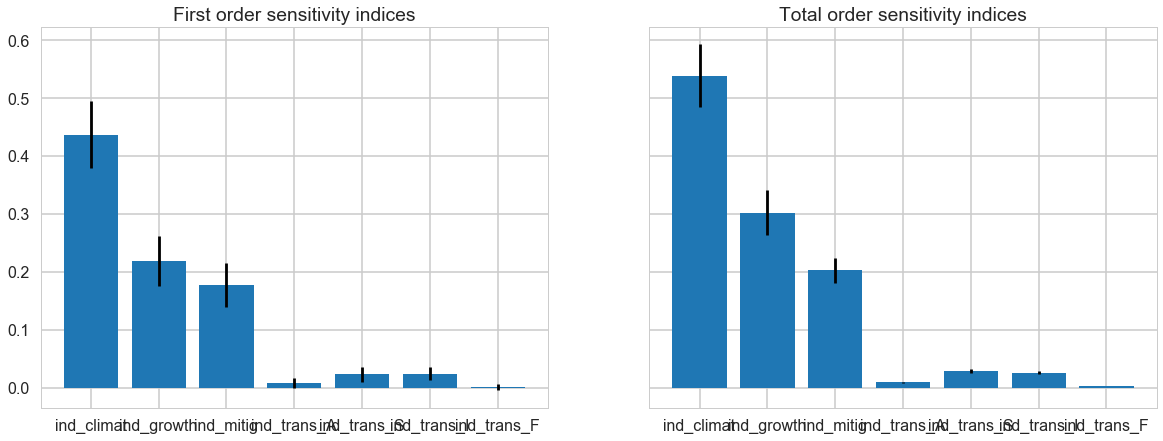

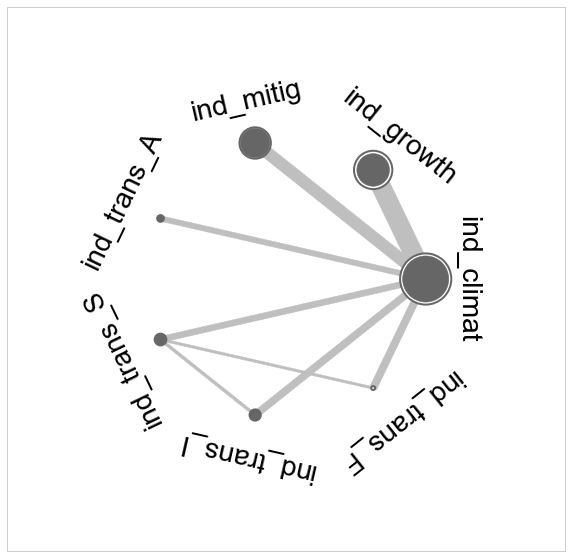

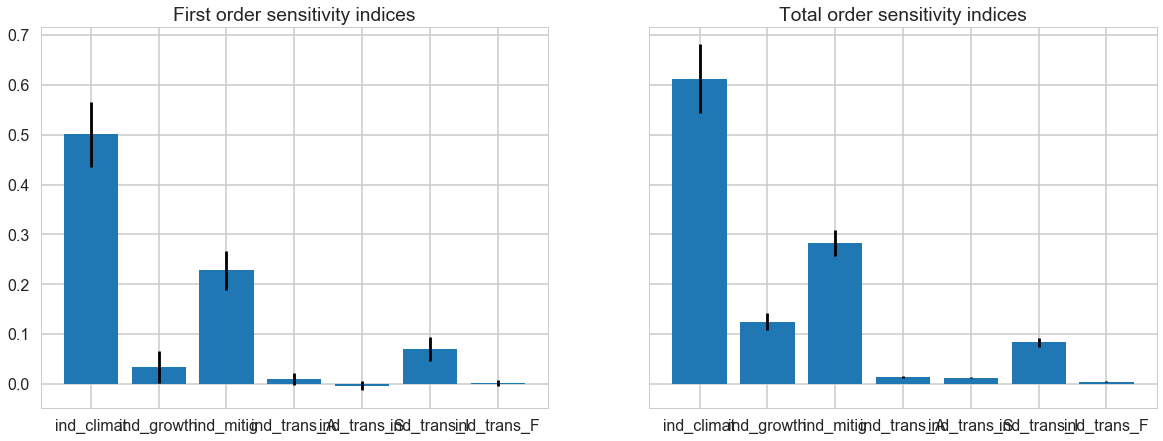

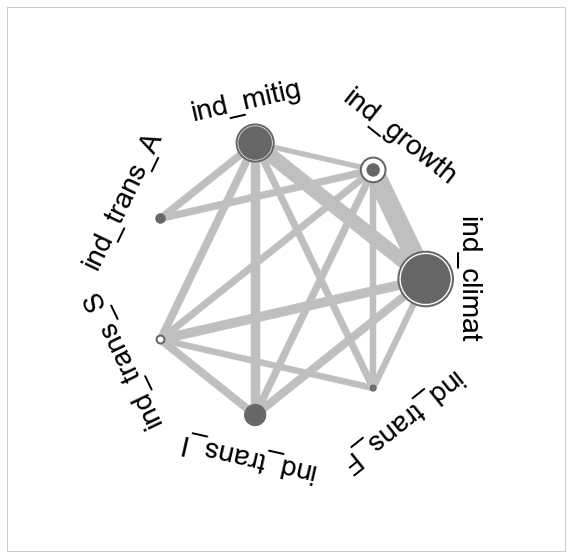

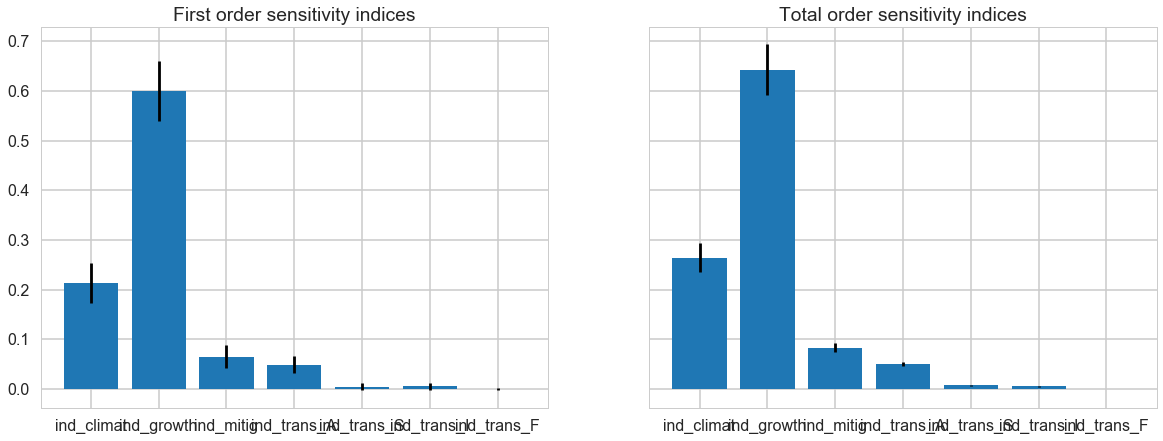

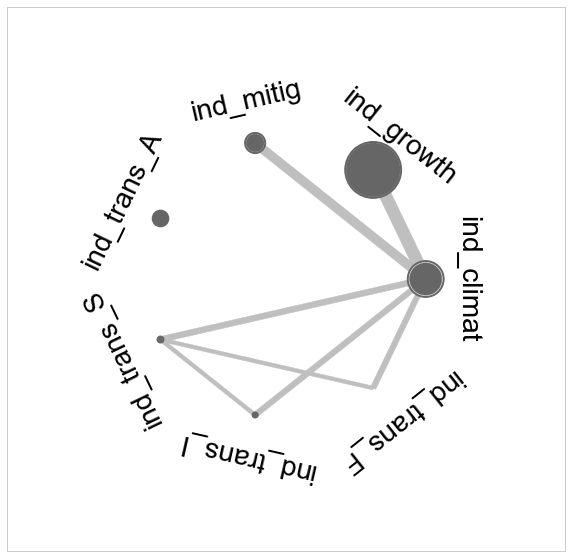

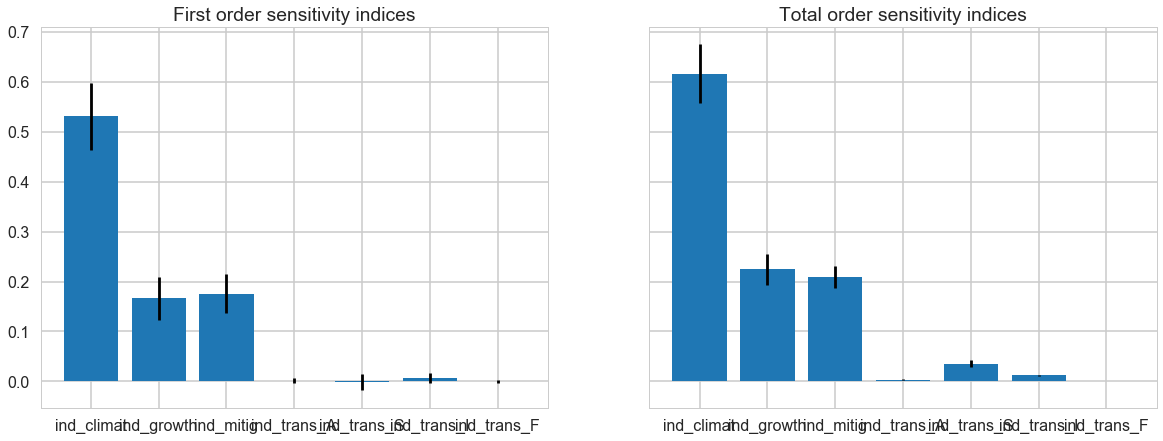

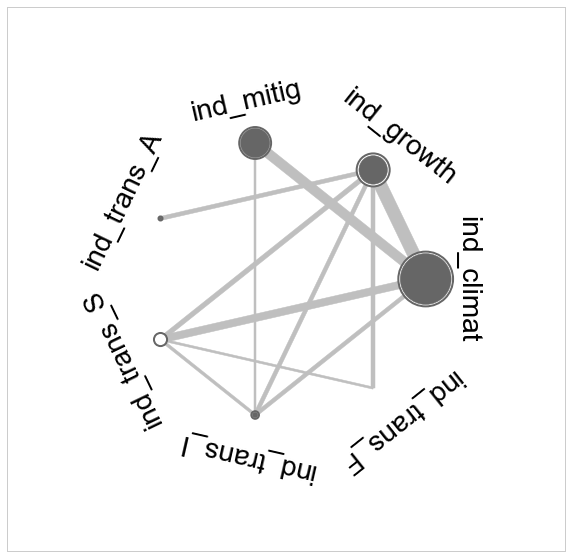

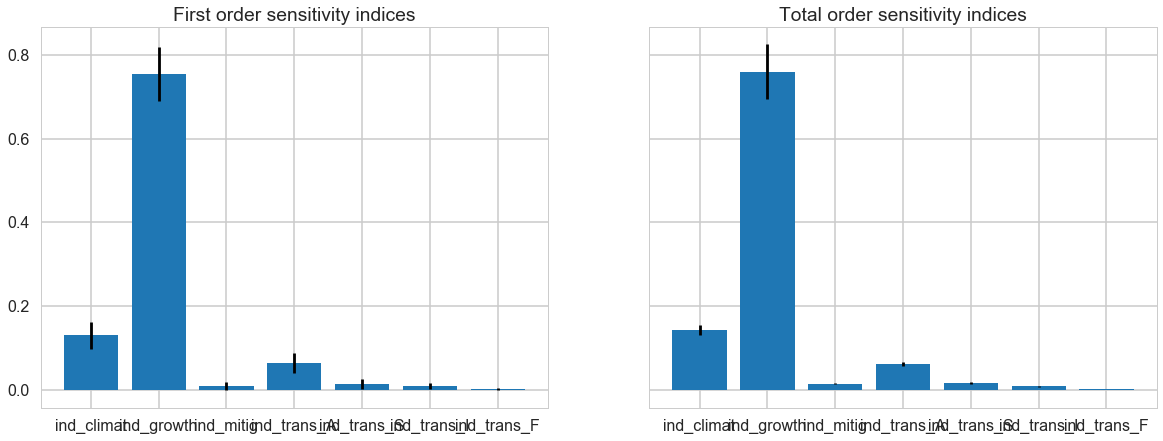

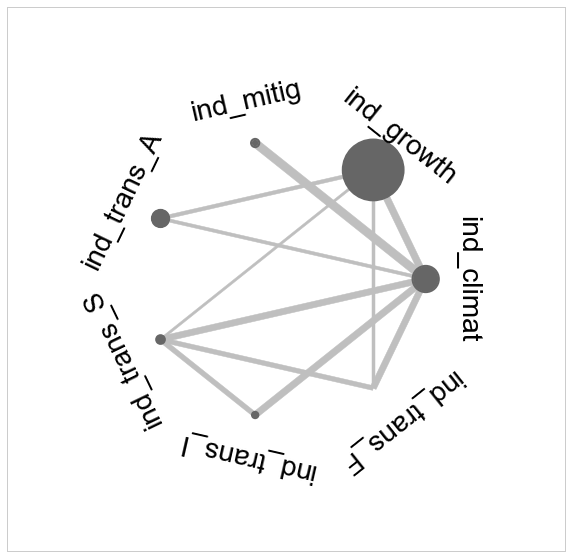

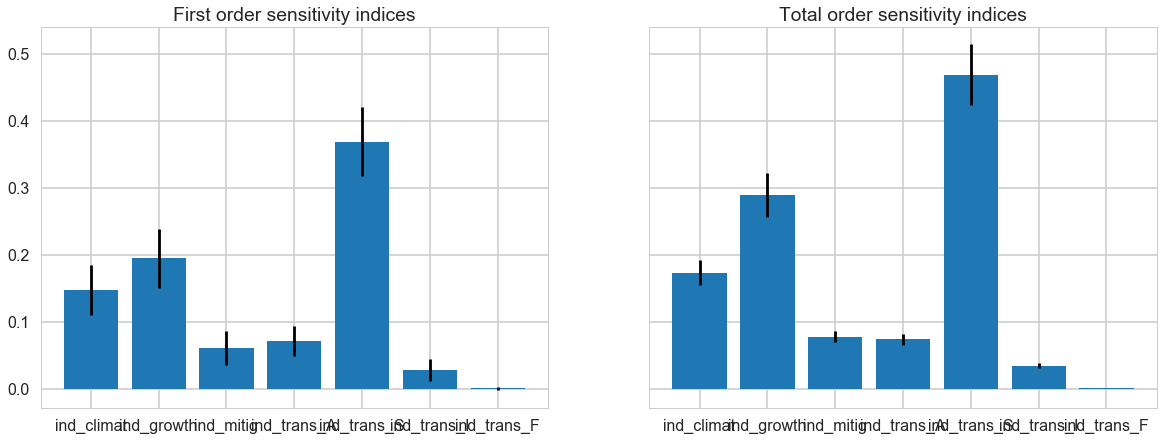

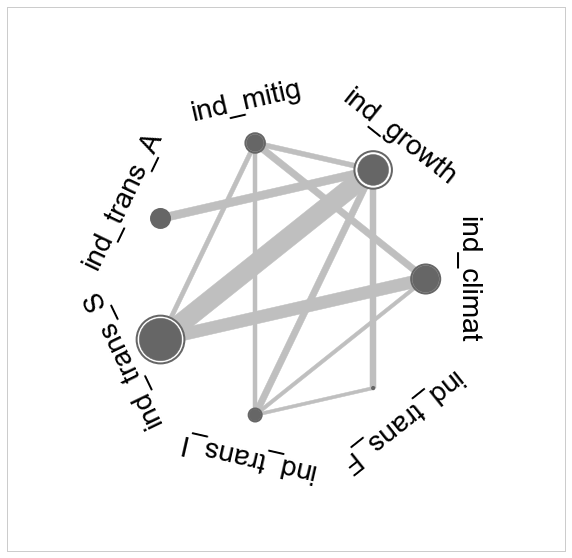

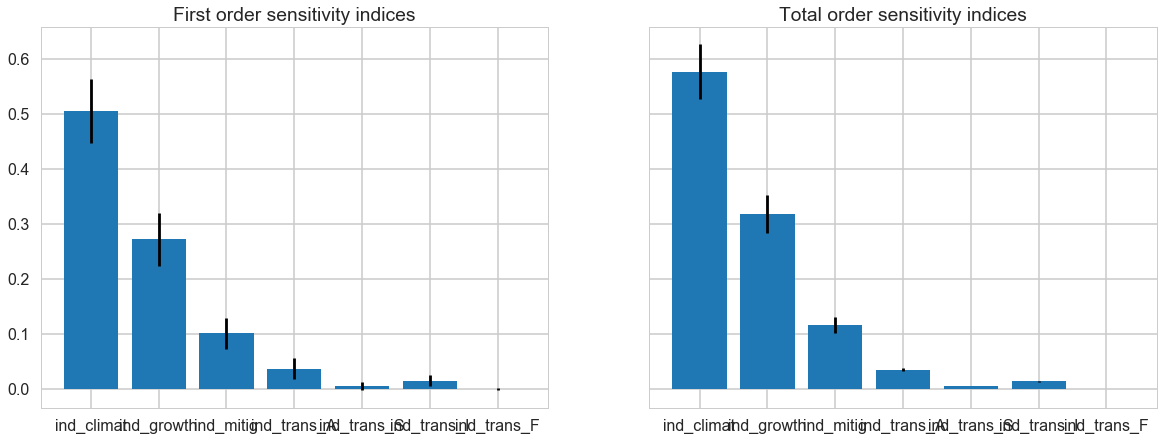

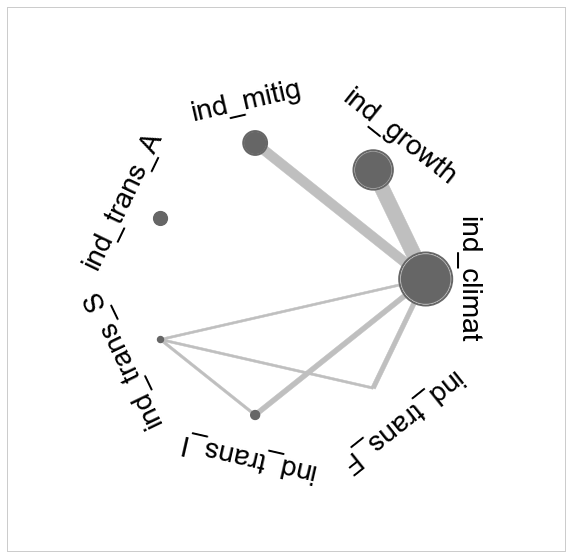

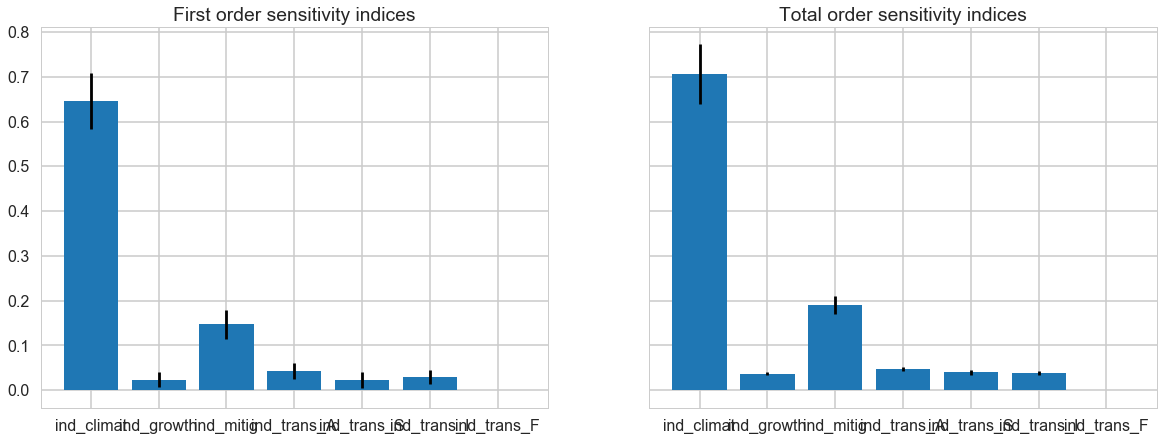

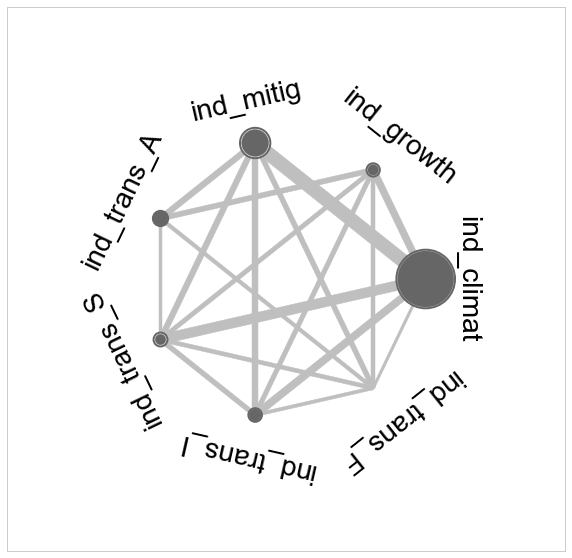

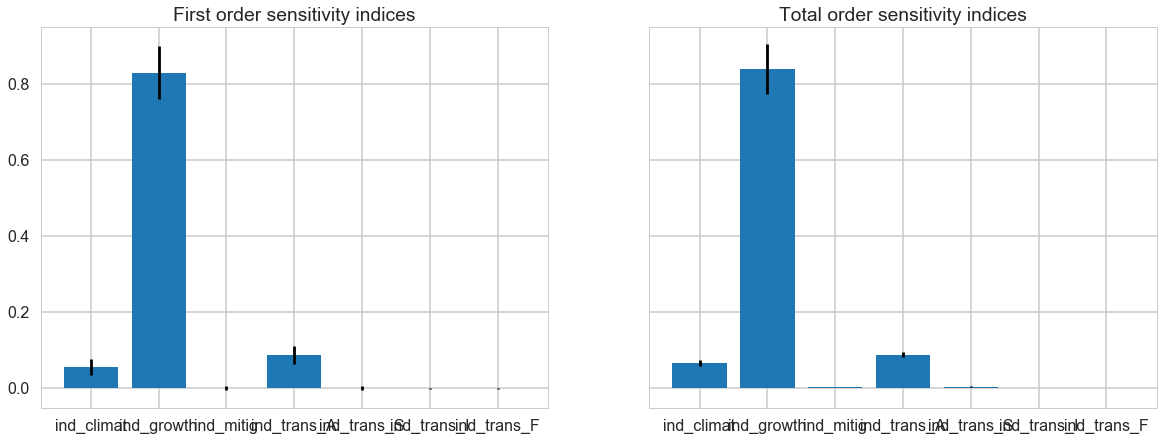

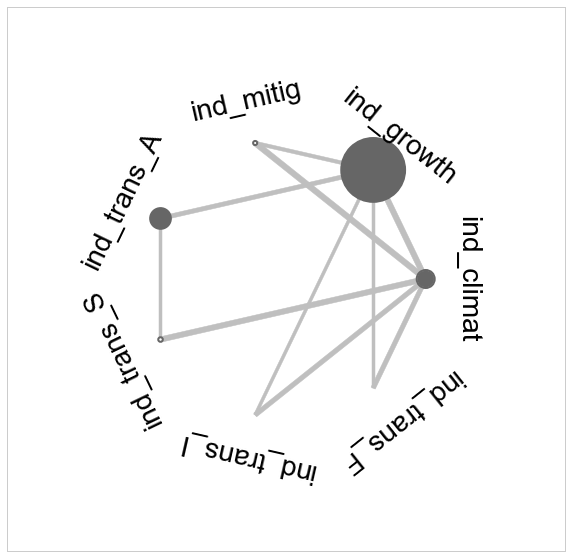

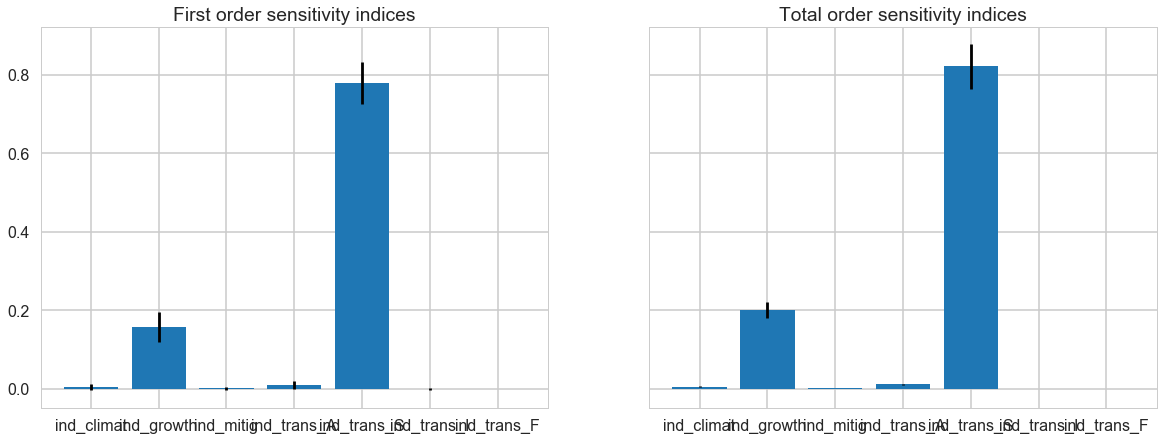

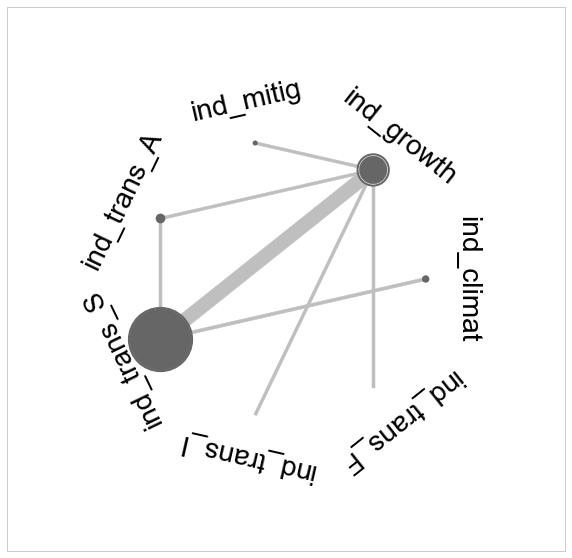

In [82]:
test = out.stack().unstack('year')['2040'].unstack('Variable')

for reg,subframe in test.groupby(level='region'):
    #I use pandas to merge the new inputs with the outputs since this is much much quicker. I use sort to make sure
    #I keep the order of the scenarios in X
    dataf = X_df.reset_index().merge(subframe.reset_index(),on=uncertainties,how="inner",sort=False).sort_values("index")
    
    Si_freight = sobol.analyze(problem, np.array(dataf["freight_activity"]), print_to_console=False, calc_second_order=True, conf_level=0.95)
    np.savetxt('sobol\\S2_fret_'+reg+'.csv', Si_freight['S2'], delimiter=',')
    np.savetxt('sobol\\S2_conf_fret_'+reg+'.csv', Si_freight['S2_conf'], delimiter=',')
    np.savetxt('sobol\\S1_fret_'+reg+'.csv', Si_freight['S1'], delimiter=',')
    np.savetxt('sobol\\S1_conf_fret_'+reg+'.csv', Si_freight['S1_conf'], delimiter=',')
    np.savetxt('sobol\\ST_fret_'+reg+'.csv', Si_freight['ST'], delimiter=',')
    np.savetxt('sobol\\ST_conf_fret_'+reg+'.csv', Si_freight['ST_conf'], delimiter=',')
    
    Si_passenger = sobol.analyze(problem, np.array(dataf["passenger_activity"]), print_to_console=False, calc_second_order=True, conf_level=0.95)
    np.savetxt('sobol\\S2_pass_'+reg+'.csv', Si_passenger['S2'], delimiter=',')
    np.savetxt('sobol\\S2_conf_pass_'+reg+'.csv', Si_passenger['S2_conf'], delimiter=',')
    np.savetxt('sobol\\S1_pass_'+reg+'.csv', Si_passenger['S1'], delimiter=',')
    np.savetxt('sobol\\S1_conf_pass_'+reg+'.csv', Si_passenger['S1_conf'], delimiter=',')
    np.savetxt('sobol\\ST_pass_'+reg+'.csv', Si_passenger['ST'], delimiter=',')
    np.savetxt('sobol\\ST_conf_pass_'+reg+'.csv', Si_passenger['ST_conf'], delimiter=',')
    
    pretty_result_f = get_pretty_result(Si_freight,problem)
    fig11 = pretty_result_f.plot()
    fig11.set_size_inches(20, 7)
    fig11.savefig("sobol\\freight_"+reg+".png")
    fig12 = pretty_result_f.plot_sobol(radSc=2.0, scaling=1, widthSc=0.5, STthick=2, varNameMult=1.3, threshold=0.001)
    fig12.set_size_inches(10, 10)
    fig12.savefig("sobol\\freight_diagram_"+reg+".png")
    
    pretty_result_p = get_pretty_result(Si_passenger,problem)
    fig22 = pretty_result_p.plot()
    fig22.set_size_inches(20, 7)
    fig22.savefig("sobol\\passengers_"+reg+".png")
    fig22 = pretty_result_p.plot_sobol(radSc=2.0, scaling=1, widthSc=0.5, STthick=2, varNameMult=1.3, threshold=0.001)
    fig22.set_size_inches(10, 10)
    fig22.savefig("sobol\\passenger_diagram_"+reg+".png")

In [19]:
test.reset_index().ind_climat.unique()

array([0, 2, 4], dtype=int64)

c:\users\wb451855\documents\rhodium\rhodium\sa.py:336: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  ax.set_axis_bgcolor('white')
c:\users\wb451855\documents\rhodium\rhodium\sa.py:292: RuntimeWarning: divide by zero encountered in double_scalars
  angle = math.atan((y[j]-y[i])/(x[j]-x[i]))


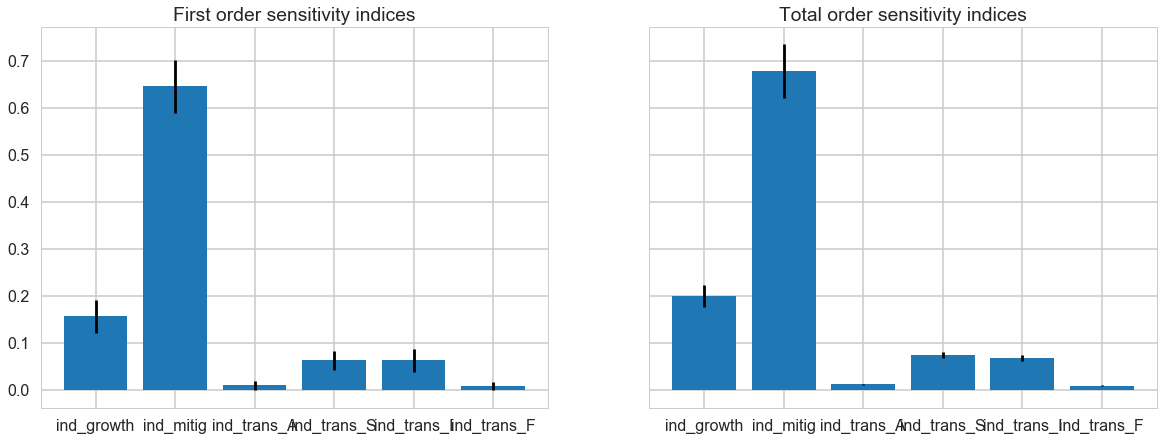

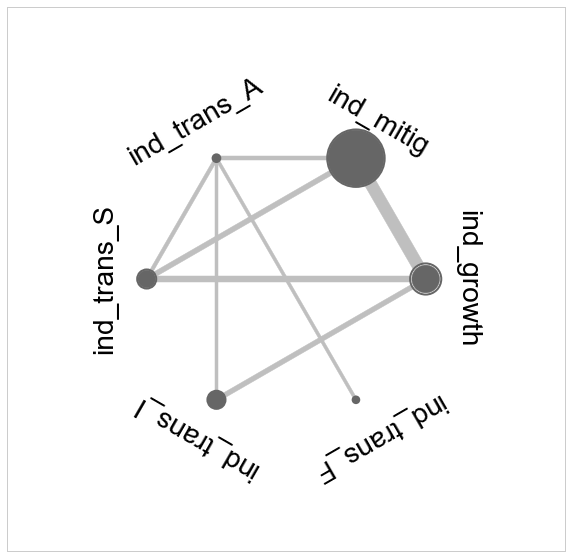

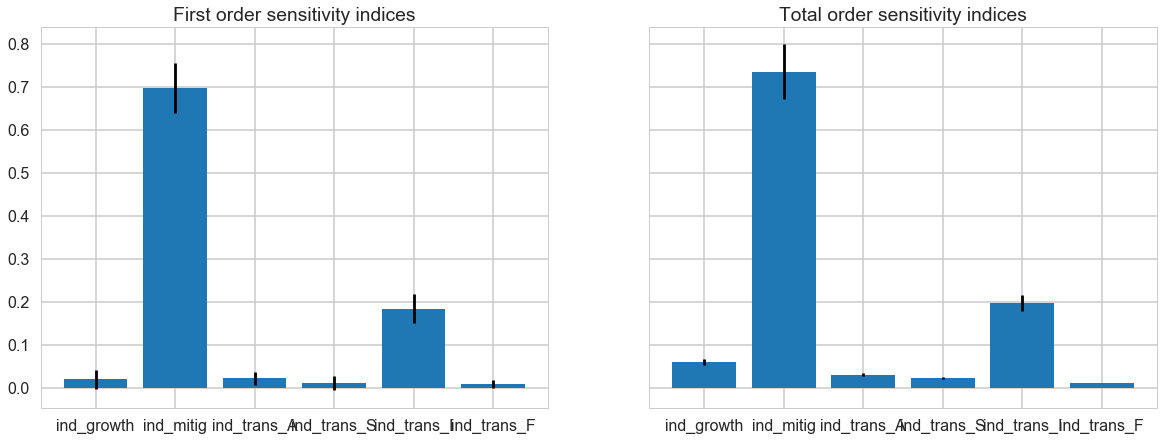

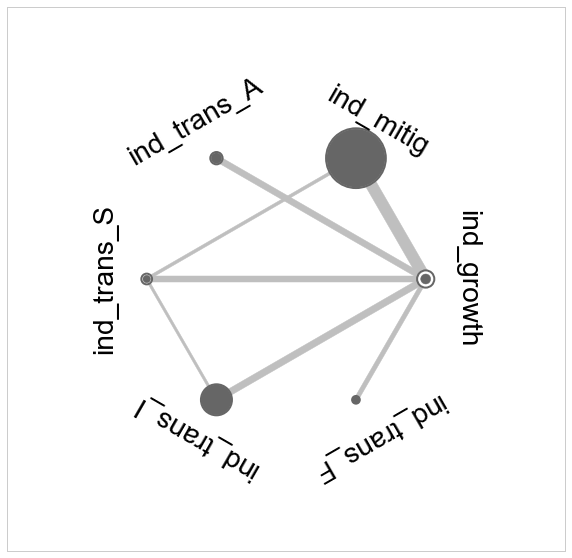

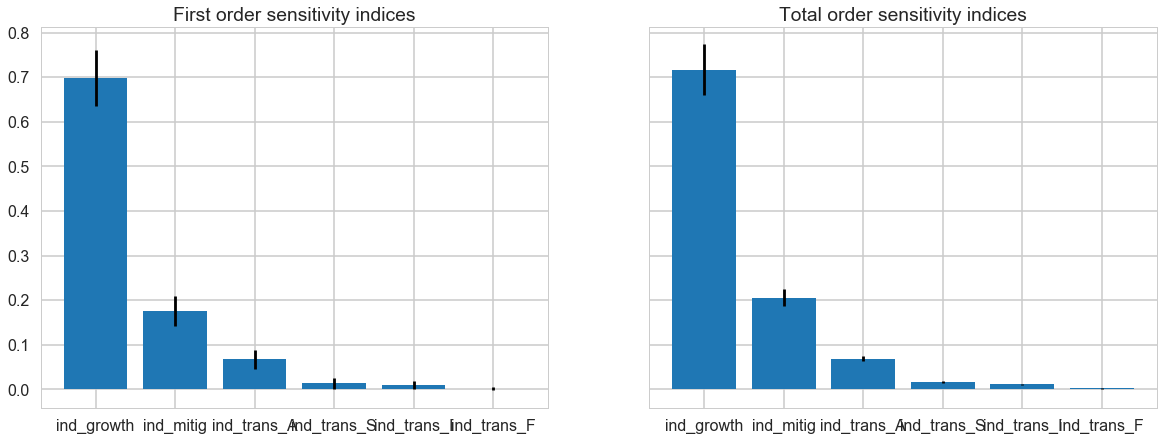

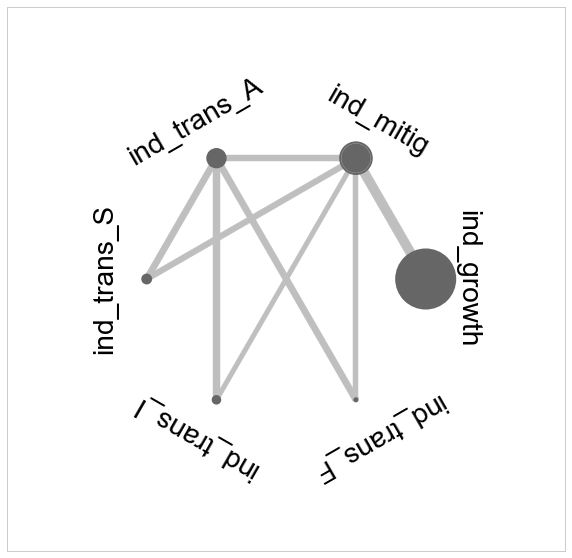

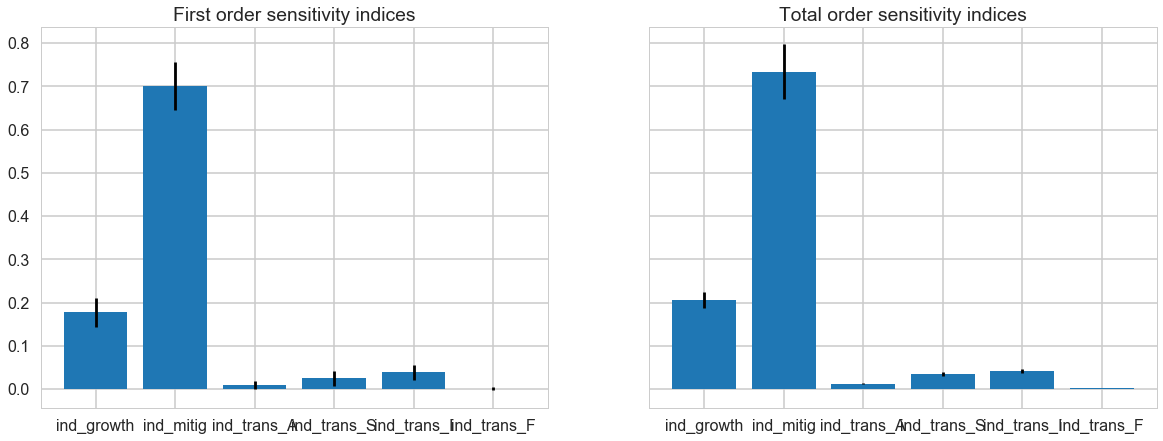

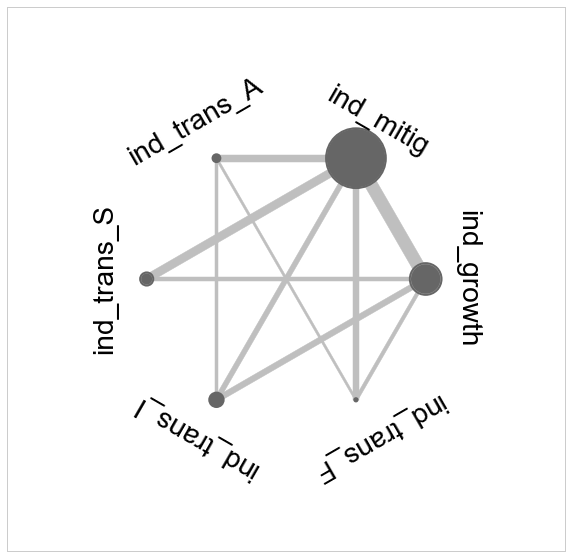

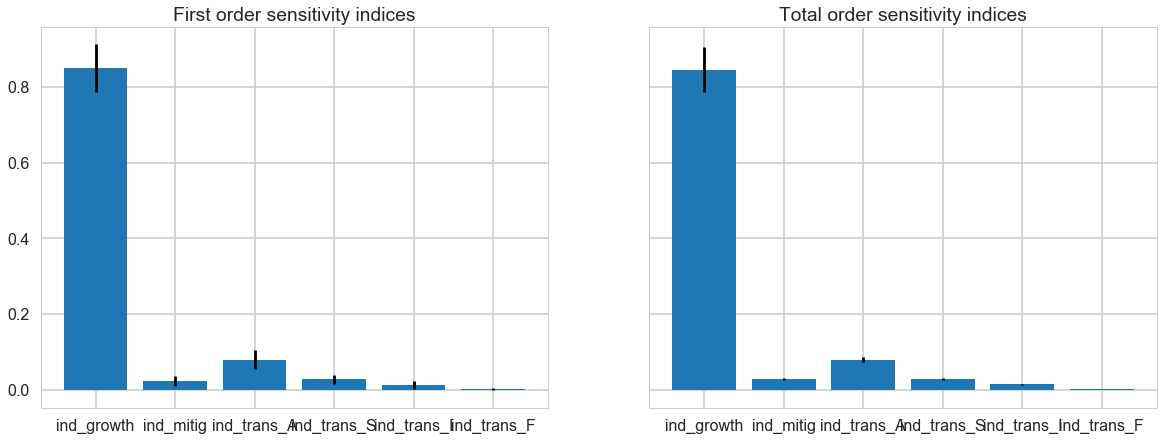

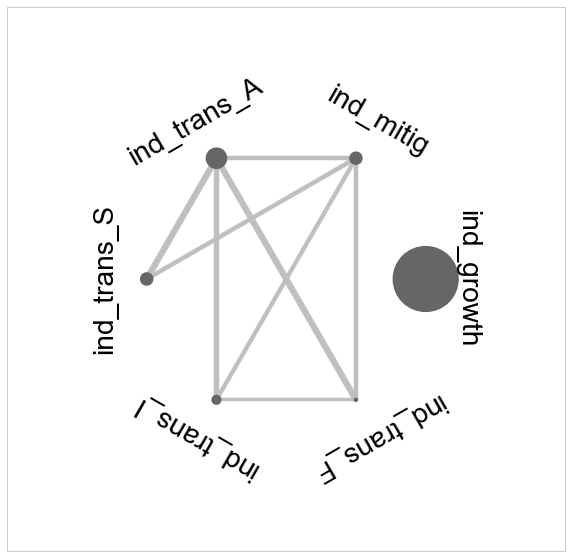

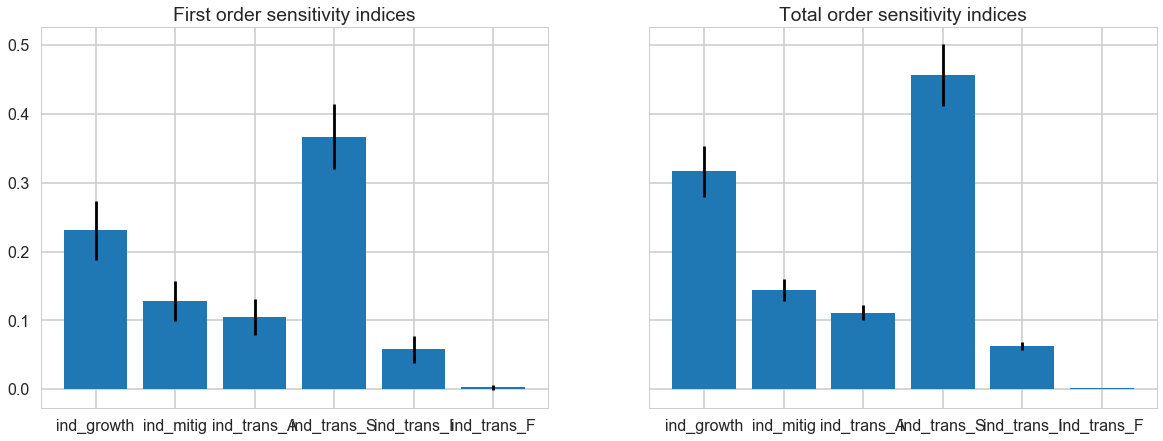

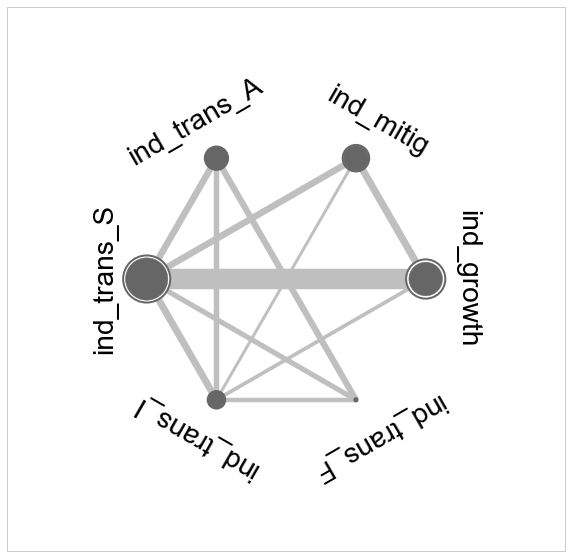

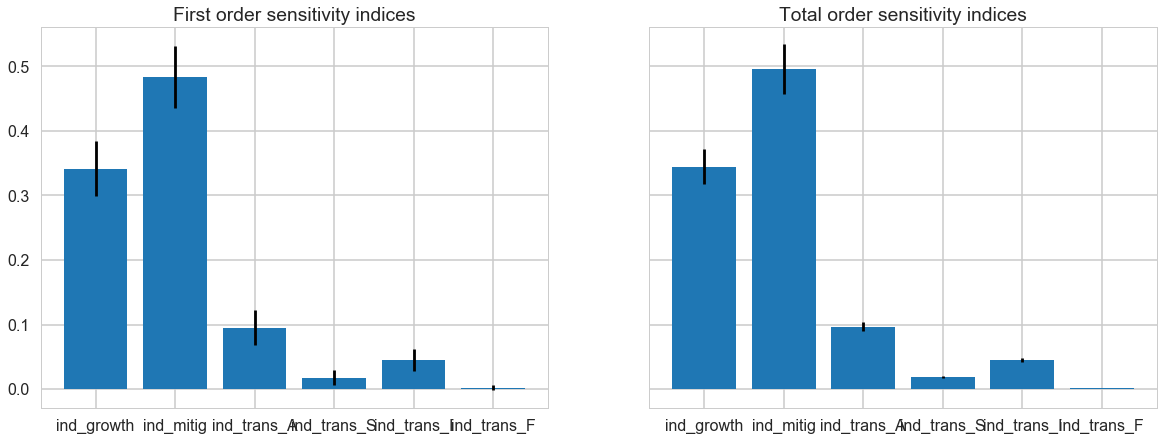

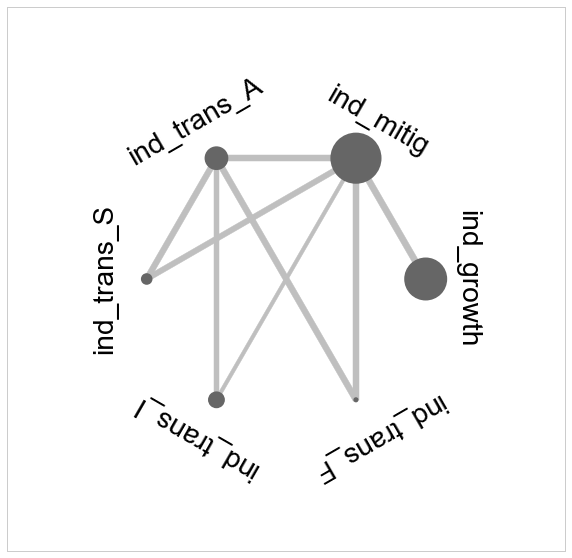

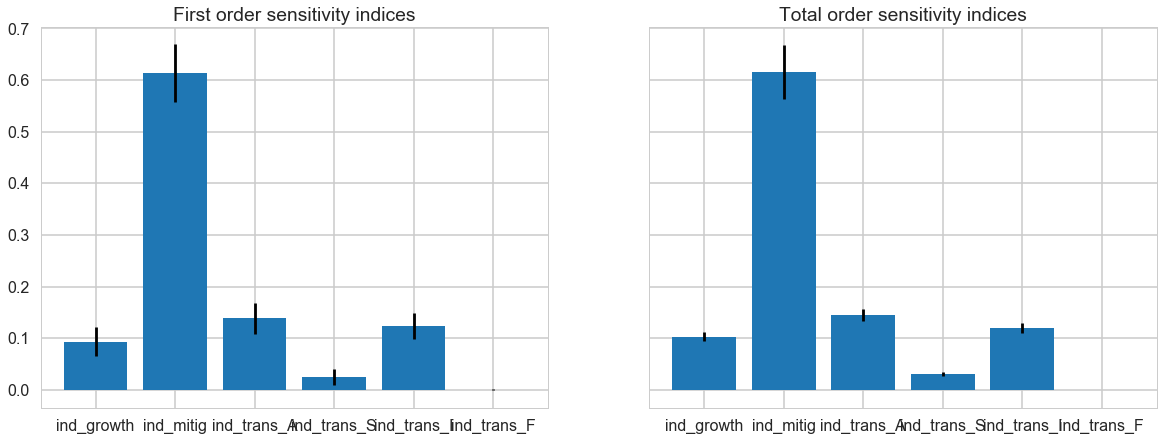

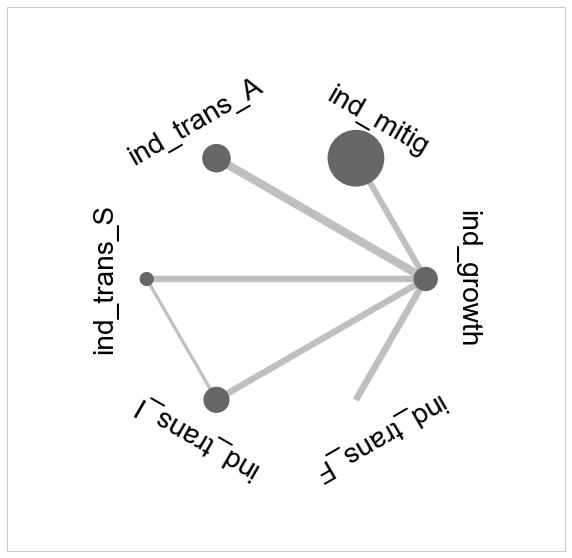

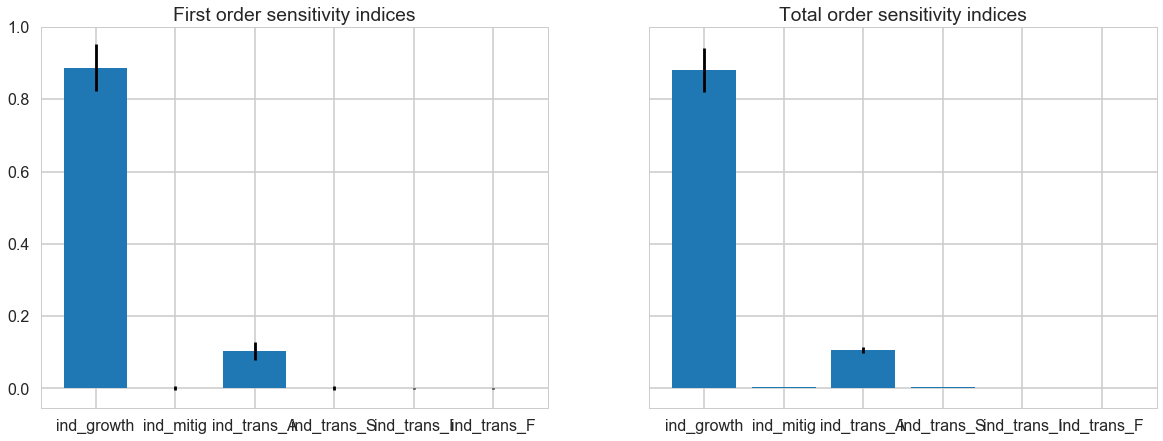

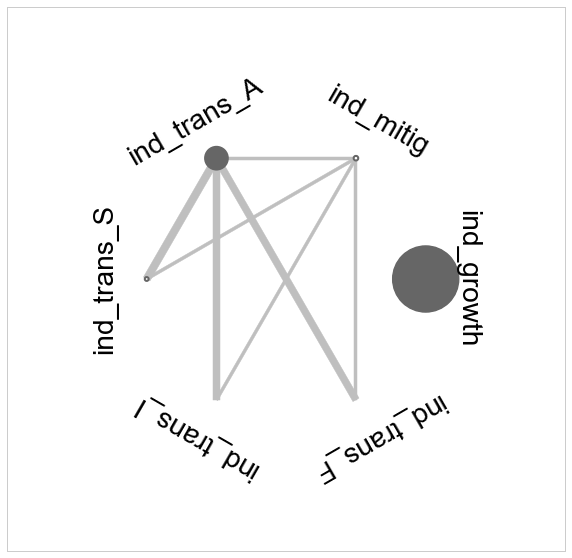

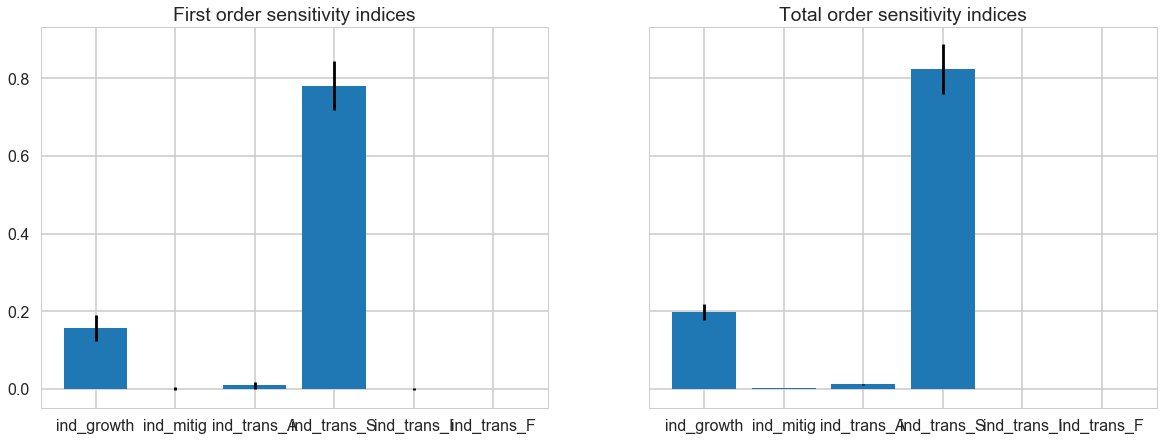

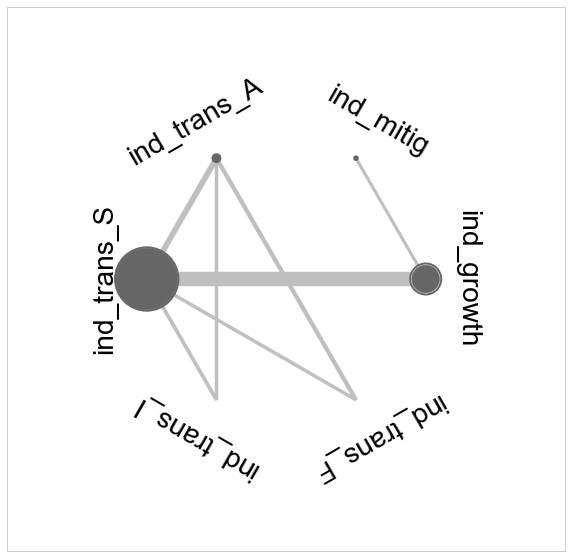

In [57]:
#low carbon only
test = out.stack().unstack("ind_climat")[[4]].stack().unstack('year')['2040'].unstack('Variable')

for reg,subframe in test.groupby(level='region'):
    #I use pandas to merge the new inputs with the outputs since this is much much quicker. I use sort to make sure
    #I keep the order of the scenarios in X
    dataf = X_df2.reset_index().merge(subframe.reset_index(),on=uncertainties2,how="inner",sort=False).sort_values("index")
    
    Si_freight = sobol.analyze(problem2, np.array(dataf["freight_activity"]), print_to_console=False, calc_second_order=True, conf_level=0.95)
    
    Si_passenger = sobol.analyze(problem2, np.array(dataf["passenger_activity"]), print_to_console=False, calc_second_order=True, conf_level=0.95)
    
    pretty_result_f = get_pretty_result(Si_freight,problem2)
    fig11 = pretty_result_f.plot()
    fig11.set_size_inches(20, 7)
    fig11.savefig("sobol\\freight_"+reg+"_climat.png")
    fig12 = pretty_result_f.plot_sobol(radSc=2.0, scaling=1, widthSc=0.5, STthick=2, varNameMult=1.3, threshold=0.001)
    fig12.set_size_inches(10, 10)
    fig12.savefig("sobol\\freight_diagram_"+reg+"_climat.png")
    
    pretty_result_p = get_pretty_result(Si_passenger,problem2)
    fig22 = pretty_result_p.plot()
    fig22.set_size_inches(20, 7)
    fig22.savefig("sobol\\passengers_"+reg+"_climat.png")
    fig22 = pretty_result_p.plot_sobol(radSc=2.0, scaling=1, widthSc=0.5, STthick=2, varNameMult=1.3, threshold=0.001)
    fig22.set_size_inches(10, 10)
    fig22.savefig("sobol\\passenger_diagram_"+reg+"_climat.png")

In [ ]:
out.multiply

### Difference compared to baseline

In [79]:
diff = out.stack().unstack("ind_climat")[[0,4]].diff(axis=1).drop(0,axis=1).rename(columns={4:"diff with 0"})

In [80]:
hop = out.stack().unstack("ind_climat")
hop["diff with 0"] = diff

In [82]:
hop["diff with 0"] = hop["diff with 0"]/hop[0]

In [86]:
test = hop["diff with 0"].unstack('year')['2040'].unstack('Variable')

test = test.reset_index()
means = test.loc[test.region=="ASIA",:].set_index(['ind_mitig',"ind_trans_I"]).passenger_activity.mean(level=['ind_mitig',"ind_trans_I"])
print(means[means==means.max()])
print(means[means==means.min()])

ind_mitig  ind_trans_I
2          2             -0.076141
Name: passenger_activity, dtype: float64
ind_mitig  ind_trans_I
1          1             -0.157281
Name: passenger_activity, dtype: float64


In [87]:
test = hop["diff with 0"].unstack('year')['2040'].unstack('Variable')

test = test.reset_index()
means = test.loc[test.region=="MAF",:].set_index(['ind_mitig',"ind_trans_A","ind_trans_I"]).passenger_activity.mean(level=['ind_mitig',"ind_trans_A","ind_trans_I"])
print(means[means==means.max()])
print(means[means==means.min()])

ind_mitig  ind_trans_A  ind_trans_I
2          1            2             -0.087979
Name: passenger_activity, dtype: float64
ind_mitig  ind_trans_A  ind_trans_I
1          2            1             -0.205422
Name: passenger_activity, dtype: float64


### difference compared to today

In [30]:
diff = out.stack().unstack("year")[['2018','2030']].diff(axis=1).drop('2018',axis=1).rename(columns={'2030':"diff 2030-2018"})

In [31]:
hop = out.stack().unstack("year")
hop["diff 2030-2018"] = diff
hop["diff 2030-2018"] = hop["diff 2030-2018"]/hop["2018"]

In [32]:
test = hop["diff 2030-2018"].unstack('Variable')

test = test.reset_index()
means = test.loc[test.region=="LAM",:].set_index(['ind_trans_A','ind_growth']).freight_activity.mean(level=['ind_trans_A','ind_growth'])
print(means[means==means.max()])
print(means[means==means.min()])

ind_trans_A  ind_growth
1            1             0.66896
Name: freight_activity, dtype: float64
ind_trans_A  ind_growth
2            3             0.399556
Name: freight_activity, dtype: float64


In [33]:
test = hop["diff 2030-2018"].unstack('Variable')

test = test.reset_index()
means = test.loc[test.region=="LAM",:].set_index(['ind_trans_S']).passenger_activity.mean(level=['ind_trans_S'])
print(means[means==means.max()])
print(means[means==means.min()])


ind_trans_S
1    0.411982
Name: passenger_activity, dtype: float64
ind_trans_S
2    0.354002
Name: passenger_activity, dtype: float64


In [36]:
test = hop["diff 2030-2018"].unstack("ind_climat")[4].unstack('Variable')

test = test.reset_index()
means = test.loc[test.region=="ASIA",:].set_index(['ind_mitig',"ind_trans_I"]).passenger_activity.mean(level=['ind_mitig',"ind_trans_I"])
print(means[means==means.max()])
print(means[means==means.min()])

means = test.loc[test.region=="ASIA",:].set_index(['ind_mitig']).freight_activity.mean(level=['ind_mitig'])
print(means[means==means.max()])
print(means[means==means.min()])

ind_mitig  ind_trans_I
2          2              0.378269
Name: passenger_activity, dtype: float64
ind_mitig  ind_trans_I
1          1              0.280623
Name: passenger_activity, dtype: float64
ind_mitig
2    0.544991
Name: freight_activity, dtype: float64
ind_mitig
1    0.372946
Name: freight_activity, dtype: float64


In [35]:
test = hop["diff 2030-2018"].unstack("ind_climat")[0].unstack('Variable')

test = test.reset_index()
means = test.loc[test.region=="ASIA",:].set_index(['ind_mitig',"ind_trans_I"]).passenger_activity.mean(level=['ind_mitig',"ind_trans_I"])
print(means[means==means.max()])
print(means[means==means.min()])

means = test.loc[test.region=="ASIA",:].set_index(['ind_mitig']).freight_activity.mean(level=['ind_mitig'])
print(means[means==means.max()])
print(means[means==means.min()])

ind_mitig  ind_trans_I
2          2              0.448966
Name: passenger_activity, dtype: float64
ind_mitig  ind_trans_I
1          1              0.400639
Name: passenger_activity, dtype: float64
ind_mitig
2    0.77874
Name: freight_activity, dtype: float64
ind_mitig
1    0.679954
Name: freight_activity, dtype: float64


In [39]:
0.55/0.78-1

-0.2948717948717948

In [40]:
0.37/0.68-1

-0.4558823529411765

In [108]:
test.region.unique()

array(['ASIA', 'CIS', 'LAM', 'MAF', 'OCDE'], dtype=object)

In [109]:
test = hop["diff 2030-2018"].unstack("ind_climat")[4].unstack('Variable')

test = test.reset_index()
means = test.loc[test.region=="MAF",:].set_index(['ind_mitig',"ind_trans_A","ind_trans_I"]).passenger_activity.mean(level=['ind_mitig',"ind_trans_A","ind_trans_I"])
print(means[means==means.max()])
print(means[means==means.min()])

ind_mitig  ind_trans_A  ind_trans_I
2          1            2              0.462657
Name: passenger_activity, dtype: float64
ind_mitig  ind_trans_A  ind_trans_I
1          2            1              0.368609
Name: passenger_activity, dtype: float64


In [110]:
test = hop["diff 2030-2018"].unstack("ind_climat")[0].unstack('Variable')

test = test.reset_index()
means = test.loc[test.region=="MAF",:].set_index(['ind_mitig',"ind_trans_A","ind_trans_I"]).passenger_activity.mean(level=['ind_mitig',"ind_trans_A","ind_trans_I"])
print(means[means==means.max()])
print(means[means==means.min()])

ind_mitig  ind_trans_A  ind_trans_I
2          2            2              0.496766
Name: passenger_activity, dtype: float64
ind_mitig  ind_trans_A  ind_trans_I
1          2            1              0.46968
Name: passenger_activity, dtype: float64


## discounted values (analysis not finished)

In [17]:
out.sample(10)

Variable                                                                                                                      CO2_em_tot  \
ind_climat ind_growth ind_mitig ind_trans_A ind_trans_S ind_trans_I ind_trans_F ind_taxexo ind_recycl ind_taxmax region year               
2          2          2         1           1           2           2           0          0          0          OCDE   2040     13824.1   
                                            2           2           1           0          0          0          LAM    2019      2350.9   
0          3          2         2           2           2           1           0          0          0          MAF    2039      6169.0   
                      1         2           2           2           1           0          0          0          MAF    2033      6827.0   
2          3          2         2           1           2           1           0          0          0          LAM    2037      2604.7   
4          2          2         1           2           2           1           0          0          0          LAM    2033      2385.6   
2          3          1         1           2           2           1           0          0          0          ASIA   2032     14109.0   
4          3          1         2           1           1           2           0          0          0          MAF    2025      3692.0   
           2          1         2           1           1           1           0          0          0          OCDE   2029     14267.3   
0          3          2         2           1           1           2           0          0          0          OCDE   2041     14120.7   

Variable                                                                                                                      CO2_em_trans  \
ind_climat ind_growth ind_mitig ind_trans_A ind_trans_S ind_trans_I ind_trans_F ind_taxexo ind_recycl ind_taxmax region year                 
2          2          2         1           1           2           2           0          0          0          OCDE   2040        6151.7   
                                            2           2           1           0          0          0          LAM    2019        1010.6   
0          3          2         2           2           2           1           0          0          0          MAF    2039        1895.6   
                      1         2           2           2           1           0          0          0          MAF    2033        1560.5   
2          3          2         2           1           2           1           0          0          0          LAM    2037        1382.9   
4          2          2         1           2           2           1           0          0          0          LAM    2033        1295.2   
2          3          1         1           2           2           1           0          0          0          ASIA   2032        2463.7   
4          3          1         2           1           1           2           0          0          0          MAF    2025        1017.6   
           2          1         2           1           1           1           0          0          0          OCDE   2029        5271.2   
0          3          2         2           1           1           2           0          0          0          OCDE   2041        5296.6   

Variable                                                                                                                          PIB  \
ind_climat ind_growth ind_mitig ind_trans_A ind_trans_S ind_trans_I ind_trans_F ind_taxexo ind_recycl ind_taxmax region year            
2          2          2         1           1           2           2           0          0          0          OCDE   2040  76756.0   
                                            2           2           1           0          0          0          LAM    2019   5850.0   
0          3          2         2           2           2         

In [159]:
out = out.reset_index()
d = 0.06
out["discount_factor"] = (1+d)**(1-(out.year.astype(int)-2014))

In [138]:
out["discounted_pib"] = out.PIB*out.discount_factor

In [139]:
out.columns

Index(['index', 'ind_climat', 'ind_growth', 'ind_mitig', 'ind_trans_A',
       'ind_trans_S', 'ind_trans_I', 'ind_trans_F', 'ind_taxexo', 'ind_recycl',
       'ind_taxmax', 'region', 'year', 'CO2_em_tot', 'CO2_em_trans', 'PIB',
       'Population', 'freight_activity', 'fret_OT', 'fret_air', 'fret_mer',
       'passenger_activity', 'pkm_OT', 'pkm_air', 'pkm_auto',
       'discount_factor', 'discounted_pib'],
      dtype='object', name='Variable')

In [140]:
pib_summed_over_time = out.set_index([x for x in indexes_ima2 if x not in ["Variable"]]).discounted_pib.sum(level=[x for x in indexes_ima2 if x not in ["Variable","year"]])

In [15]:
to_merge = out.reset_index().set_index([x for x in indexes_ima2 if x not in ["Variable"]])["PIB"]

# Now I look at a different dataset that contains investment needs

In [16]:
indexes_inv = ['combi', 'ind_climat', 'ind_growth', 'ind_mitig', 'ind_trans_A',
       'ind_trans_S', 'ind_trans_I', 'ind_trans_F', 'modal_scenario',
        'ur_ideal', 'urt_ideal','delay','costs_evolution_road', 'costs_evolution_rail']

In [45]:
reg = os.listdir(invfolder)[0]
myfilename = os.listdir(invfolder+reg)[0]

In [46]:
myfile = pd.read_csv(invfolder+reg+"\\"+myfilename,sep=";")
myfile = myfile.set_index(indexes_inv)
myfile.columns.name='year'
myfile = myfile.drop(['2031','2032','2033','2034','2035','2036','2037','2038',
'2039', '2040' , '2041', '2042', '2043', '2044', '2045', '2046', '2047', '2048',
'2049','2050', '2051', '2052', '2053', '2054', '2055', '2056', '2057', '2058',
'2059', '2060', '2061', '2062', '2063', '2064', '2065', '2066', '2067',
'2068', '2069', '2070', '2071', '2072', '2073', '2074', '2075', '2076',
'2077', '2078', '2079', '2080'],axis=1)
myfile = myfile.stack('year')
myfile.name = 'value'
myfile = myfile.reset_index()

In [48]:
myfile.shape

(995328, 16)

In [49]:
myinfo = myfilename.replace(".csv",'').split("_")
myfile["costtype"] = myinfo[1]
myfile["transpmode"] = myinfo[2]
myfile["region"] = reg

myfile = myfile.merge(to_merge.reset_index(),on=['ind_climat', 'ind_growth', 'ind_mitig', 'ind_trans_A',
'ind_trans_S', 'ind_trans_I', 'ind_trans_F','region', 'year'],how="left")

In [50]:
myfile.shape

(995328, 23)

In [56]:
global_file = myfile.set_index(indexes_inv+["costtype","transpmode","region","year"])[["PIB","value"]]

In [58]:
global_file.sum(level=indexes_inv+["costtype","transpmode","year"]).shape

(995328, 2)

In [53]:
global_file.shape

(995328, 2)

In [54]:
global_file.sample(3)

,,,,,,,,,,,,,,,,,PIB,value
combi,ind_climat,ind_growth,ind_mitig,ind_trans_A,ind_trans_S,ind_trans_I,ind_trans_F,modal_scenario,ur_ideal,urt_ideal,delay,costs_evolution_road,costs_evolution_rail,costtype,transpmode,year,,
185,2,3,2,2,1,1,1,0,600,5000,35,2,2,maint,air,2017,9451.0,0.444082
313,4,1,2,2,1,1,1,0,900,30000,35,1,0,maint,air,2022,14528.0,0.644850
10,0,1,1,2,1,1,2,0,900,5000,65,2,1,maint,air,2020,17205.0,0.577900


In [59]:
all_data_global = pd.DataFrame()
for reg in os.listdir(invfolder):
    for myfilename in os.listdir(invfolder+reg):
        myfile = pd.read_csv(invfolder+reg+"\\"+myfilename,sep=";")
        myfile = myfile.set_index(indexes_inv)
        myfile.columns.name='year'
        myfile = myfile.drop(['2031','2032','2033','2034','2035','2036','2037','2038',
       '2039', '2040' , '2041', '2042', '2043', '2044', '2045', '2046', '2047', '2048',
       '2049','2050', '2051', '2052', '2053', '2054', '2055', '2056', '2057', '2058',
       '2059', '2060', '2061', '2062', '2063', '2064', '2065', '2066', '2067',
       '2068', '2069', '2070', '2071', '2072', '2073', '2074', '2075', '2076',
       '2077', '2078', '2079', '2080'],axis=1)
        myfile = myfile.stack('year')
        myfile.name = 'value'
        myfile = myfile.reset_index()
                
        myinfo = myfilename.replace(".csv",'').split("_")
        myfile["costtype"] = myinfo[1]
        myfile["transpmode"] = myinfo[2]
        myfile["region"] = reg
        
        myfile = myfile.merge(to_merge.reset_index(),on=['ind_climat', 'ind_growth', 'ind_mitig', 'ind_trans_A',
       'ind_trans_S', 'ind_trans_I', 'ind_trans_F','region', 'year'],how="left")
        
        global_file = myfile.set_index(indexes_inv+["costtype","transpmode","region","year"])[["PIB","value"]]
        
        all_data_global = all_data_global.append(global_file)

In [62]:
all_data_global = all_data_global.sum(level = indexes_inv+["costtype","transpmode","year"])
all_data_global["divided_by_gdp"] = all_data_global.value/all_data_global.PIB
all_data_global = all_data_global["divided_by_gdp"].mean(level=indexes_inv+["costtype","transpmode"])

In [63]:
all_data_global.to_csv("C:\\Users\\WB451855\\OneDrive - WBG\\!infra_needs_data\\transport_cired_output_data\\"+"summarize_global_costs.csv")

In [ ]:
all_data_global = pd.read_csv("C:\\Users\\WB451855\\OneDrive - WBG\\!infra_needs_data\\transport_cired_output_data\\"+"summarize_global_costs.csv")

In [61]:
all_data_global = all_data_global.set_index(indexes_inv+["costtype","transpmode"])

KeyError: 'combi'

In [216]:
all_data = pd.DataFrame()
for reg in os.listdir(invfolder):
    for myfilename in os.listdir(invfolder+reg):
        myfile = pd.read_csv(invfolder+reg+"\\"+myfilename,sep=";")
        myfile = myfile.set_index(indexes_inv)
        myfile.columns.name='year'
        myfile = myfile.drop(['2031','2032','2033','2034','2035','2036','2037','2038',
       '2039', '2040' , '2041', '2042', '2043', '2044', '2045', '2046', '2047', '2048',
       '2049','2050', '2051', '2052', '2053', '2054', '2055', '2056', '2057', '2058',
       '2059', '2060', '2061', '2062', '2063', '2064', '2065', '2066', '2067',
       '2068', '2069', '2070', '2071', '2072', '2073', '2074', '2075', '2076',
       '2077', '2078', '2079', '2080'],axis=1)
        myfile = myfile.stack('year')
        myfile.name = 'value'
        myfile = myfile.reset_index()
        myfile["discount_factor"] = (1+d)**(1-(myfile.year.astype(int)-2014))
        myfile['disc_value'] =  myfile['value']*myfile["discount_factor"]
        
        myinfo = myfilename.replace(".csv",'').split("_")
        myfile["costtype"] = myinfo[1]
        myfile["transpmode"] = myinfo[2]
        myfile["region"] = reg
        
        myfile = myfile.merge(to_merge.reset_index(),on=['ind_climat', 'ind_growth', 'ind_mitig', 'ind_trans_A',
       'ind_trans_S', 'ind_trans_I', 'ind_trans_F','region', 'year'],how="left")
        
        myfile["divided_by_gdp"] = myfile.value/myfile.PIB
        myfile["discounted_gdp"] = myfile.PIB*myfile["discount_factor"]
        
        out = myfile.drop(["year","discount_factor"],axis=1).set_index(indexes_inv+["costtype","transpmode","region"])[["divided_by_gdp","value"]].mean(level=indexes_inv+["costtype","transpmode","region"])
        out["disc_value"] = myfile.drop(["year","discount_factor"],axis=1).set_index(indexes_inv+["costtype","transpmode","region"])[["disc_value"]].sum(level=indexes_inv+["costtype","transpmode","region"])
        out["discounted_gdp"] = myfile.drop(["year","discount_factor"],axis=1).set_index(indexes_inv+["costtype","transpmode","region"])[["discounted_gdp"]].sum(level=indexes_inv+["costtype","transpmode","region"])
        
        all_data = all_data.append(out)

In [217]:
all_data.to_csv("C:\\Users\\WB451855\\OneDrive - WBG\\!infra_needs_data\\transport_cired_output_data\\"+"summarize_costs.csv")

In [47]:
all_data = pd.read_csv("C:\\Users\\WB451855\\OneDrive - WBG\\!infra_needs_data\\transport_cired_output_data\\"+"summarize_costs.csv")

In [43]:
all_data.columns

Index(['combi', 'ind_climat', 'ind_growth', 'ind_mitig', 'ind_trans_A',
       'ind_trans_S', 'ind_trans_I', 'ind_trans_F', 'modal_scenario',
       'ur_ideal', 'urt_ideal', 'delay', 'costs_evolution_road',
       'costs_evolution_rail', 'costtype', 'transpmode', 'region',
       'divided_by_gdp', 'value', 'disc_value', 'discounted_gdp'],
      dtype='object')

In [48]:
indexes_inv2 = ["costtype","transpmode","region"]

In [49]:
all_data.divided_by_gdp.describe()

count    3.110400e+06
mean     3.086226e-03
std      6.557811e-03
min      0.000000e+00
25%      1.579677e-05
50%      2.207328e-04
75%      1.479827e-03
max      5.796029e-02
Name: divided_by_gdp, dtype: float64

In [50]:
all_data = all_data.loc[all_data.ur_ideal>300,:]

In [65]:
all_data_global.shape

(622080,)

In [66]:
all_data_global.sample(3)

combi  ind_climat  ind_growth  ind_mitig  ind_trans_A  ind_trans_S  ind_trans_I  ind_trans_F  modal_scenario  ur_ideal  urt_ideal  delay  costs_evolution_road  costs_evolution_rail  costtype  transpmode
67     0           3           1          1            1            2            1            0               900       5000       35     2                     0                     new       brt           0.000007
36     0           2           1          1            1            2            2            0               900       5000       65     0                     1                     new       hsr           0.000775
94     0           3           2          2            2            1            2            1               600       30000      65     1                     1                     maint     hsr           0.000455
Name: divided_by_gdp, dtype: float64

In [67]:
all_data_global = all_data_global.unstack("transpmode")
all_data_global["rail+high speed rail"] = all_data_global["rail"]+all_data_global['hsr']
all_data_global["allmodes"] = all_data_global["rail"]+all_data_global['hsr']+all_data_global["air"]+all_data_global['brt']+all_data_global['road']


In [70]:
all_data_global.allmodes.drop("maint",level="costtype").describe()

count    62208.000000
mean         0.009763
std          0.005623
min          0.002032
25%          0.005166
50%          0.008475
75%          0.012368
max          0.031596
Name: allmodes, dtype: float64

In [71]:
all_data_global.allmodes.drop("new",level="costtype").describe()

count    62208.000000
mean         0.012070
std          0.001140
min          0.009400
25%          0.011187
50%          0.012013
75%          0.012913
max          0.015894
Name: allmodes, dtype: float64

In [53]:
all_data = all_data.set_index(indexes_inv+indexes_inv2)
all_data = all_data.stack().unstack("transpmode")
all_data["rail+high speed rail"] = all_data["rail"]+all_data['hsr']
all_data["allmodes"] = all_data["rail"]+all_data['hsr']+all_data["air"]+all_data['brt']+all_data['road']
all_data = all_data.stack().unstack("columns")

In [54]:
all_data.reset_index("transpmode").transpmode.unique()

array(['air', 'brt', 'hsr', 'rail', 'road', 'rail+high speed rail',
       'allmodes'], dtype=object)

In [55]:
world = all_data.stack().unstack("region").sum(axis=1)

In [56]:
world.unstack("columns").columns

Index(['divided_by_gdp', 'value', 'disc_value', 'discounted_gdp'], dtype='object', name='columns')

In [57]:
world = world.unstack("columns")
world["divided_by_gdp"] = world.disc_value/world.discounted_gdp

In [58]:
world.columns

Index(['divided_by_gdp', 'value', 'disc_value', 'discounted_gdp'], dtype='object', name='columns')

In [59]:
dev_world = all_data.stack().unstack("region").drop("OCDE",axis=1).sum(axis=1)

In [60]:
dev_world = dev_world.unstack("columns")
dev_world["divided_by_gdp"] = dev_world.disc_value/dev_world.discounted_gdp

In [61]:
dev_world.divided_by_gdp.unstack("costtype")["new"].unstack("transpmode")['allmodes'].describe()

count    41472.000000
mean         0.003003
std          0.001039
min          0.001043
25%          0.002175
50%          0.002770
75%          0.003764
max          0.006537
Name: allmodes, dtype: float64

In [62]:
dev_world.disc_value.unstack("costtype")["new"].unstack("transpmode")['allmodes'].describe()

count    41472.000000
mean      4471.871979
std       1586.703538
min       1282.288288
25%       3241.739707
50%       4153.483499
75%       5597.622848
max       9608.907676
Name: allmodes, dtype: float64

In [63]:
dev_world.disc_value.unstack("costtype")["maint"].unstack("transpmode")['allmodes'].describe()

count    41472.000000
mean      4375.404984
std        179.774246
min       3974.497240
25%       4231.953499
50%       4372.655683
75%       4516.628126
max       4865.187120
Name: allmodes, dtype: float64

In [64]:
def drivers_from_anova2(varin,mydata):
    formula=varin+" ~ ind_climat+ind_growth+ind_mitig+ind_trans_A+ind_trans_S+ind_trans_I+ind_trans_F+modal_scenario+ur_ideal+urt_ideal+delay+costs_evolution_road+costs_evolution_rail"
    olsmodel=ols(formula,data=mydata).fit()
    table=anova_lm(olsmodel)
    table['sum_sq_pc']=table['sum_sq']/table['sum_sq'].sum()
    table=table.sort_values(by=['sum_sq'],ascending=False)
    sumvar=0
    drivers=list()
    for var in table.index:
        if var!='Residual':
            drivers.append(var)
            sumvar+=table.loc[var,'sum_sq_pc']
        if len(drivers)==3:
            break
    return drivers,sumvar

In [345]:
test = all_data.stack().unstack("transpmode")["allmodes"].unstack("columns")

for reg,subframe in test.groupby(level='region'):
    drivers,sumvar = drivers_from_anova2("divided_by_gdp",subframe.reset_index())
    print(reg,drivers,sumvar)

C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


ASIA ['ind_growth', 'urt_ideal', 'modal_scenario'] 0.138210532409
CIS ['urt_ideal', 'ind_growth', 'delay'] 0.222155442472
LAM ['urt_ideal', 'modal_scenario', 'delay'] 0.125379790975
MAF ['ur_ideal', 'urt_ideal', 'modal_scenario'] 0.112860512315
OCDE ['urt_ideal', 'ur_ideal', 'ind_trans_S'] 0.0241683580743


In [346]:
all_data.divided_by_gdp.unstack("transpmode")["allmodes"].describe()

count    414720.000000
mean          0.013628
std           0.009648
min           0.000169
25%           0.006687
50%           0.010982
75%           0.019617
max           0.061068
Name: allmodes, dtype: float64

In [65]:
bob = all_data.disc_value.unstack("transpmode").drop(['rail','hsr'],axis=1).stack().unstack("costtype")["new"]
bob = bob.reset_index()
#bob = bob.loc[bob.region!="OCDE",:]
bob["region"] = bob.region.replace({"MAF":"Middle East\nand Africa",\
                                      "LAM":"Latin America\nand Caribbean",\
                                      "CIS":"Former\nSoviet Union",\
                                      "ASIA":"Asia",\
                                      "OCDE":"OECD"})

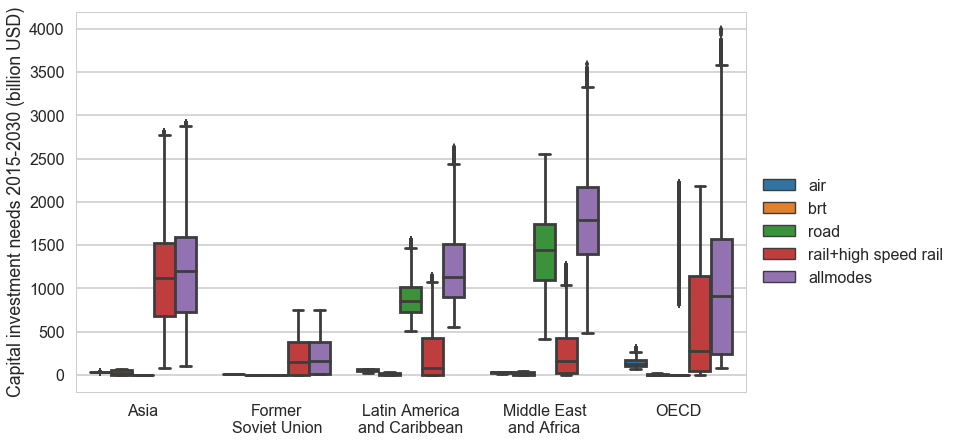

In [24]:
fig2, ax2 = plt.subplots()
sns.boxplot(x="region",y="new",hue="transpmode",data=bob,ax=ax2)
fig2.set_size_inches(12, 7)
ax2.set_xlabel("")
ax2.set_ylabel("Capital investment needs 2015-2030 (billion USD)")
plt.legend(title="",bbox_to_anchor=(1.005, 0.6))
plt.savefig("imaclim_per_region_mode.png",ddpi=300,bbox_inches="tight")
plt.savefig("imaclim_per_region_mode.pdf")

In [58]:
bob2 = all_data.divided_by_gdp.unstack("transpmode").drop(['rail','hsr'],axis=1).stack().unstack("costtype")["new"]
bob2 = bob2.reset_index()
#bob2 = bob2.loc[bob2.region!="OCDE",:]
bob2["region"] = bob2.region.replace({"MAF":"Middle East\nand Africa",\
                                      "LAM":"Latin America\nand Caribbean",\
                                      "CIS":"Former\nSoviet Union",\
                                      "ASIA":"Asia",\
                                      "OCDE":"OECD"})
bob2["new"] = 100*bob2.new

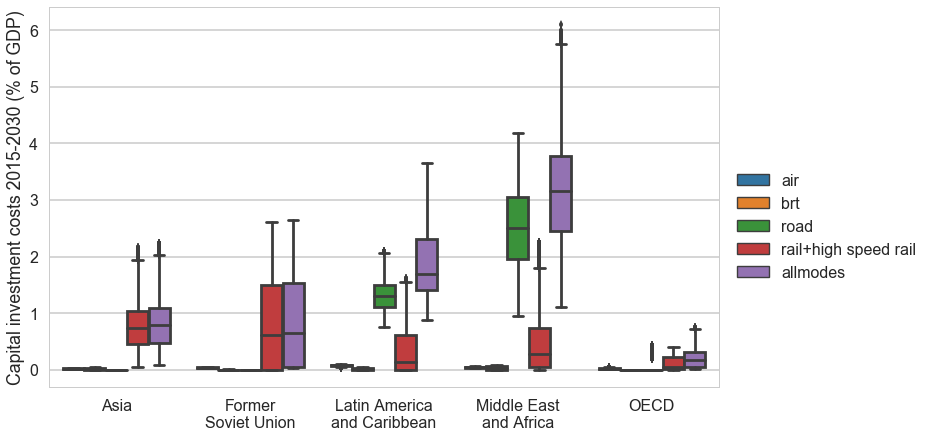

In [59]:
fig3, ax3 = plt.subplots()
sns.boxplot(x="region",y="new",hue="transpmode",data=bob2,ax=ax3)
fig3.set_size_inches(12, 7)
ax3.set_xlabel("")
ax3.set_ylabel("Capital investment costs 2015-2030 (% of GDP)")
plt.legend(title="",bbox_to_anchor=(1.005, 0.6))
plt.savefig("imaclim_per_region_mode_share_gdp.png",ddpi=300,bbox_inches="tight")
plt.savefig("imaclim_per_region_mode_share_gdp.pdf")

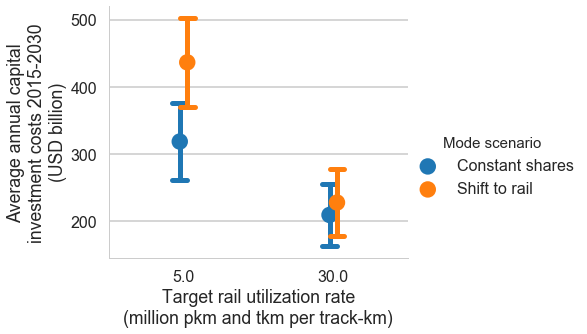

In [75]:
bob3 = dev_world.disc_value.unstack("costtype")["new"].unstack("transpmode")['allmodes'].reset_index()
bob3['modal_scenario'] = bob3.modal_scenario.replace({0:"Constant shares",1:"Shift to rail"})

#transforms sum in annual average
bob3['allmodes'] = 1/15*bob3.allmodes

bob3['urt_ideal'] = 1/1000*bob3.urt_ideal

g = sns.factorplot(x="urt_ideal",y="allmodes",hue="modal_scenario",dodge=True,ci='sd',join=False,\
              kind="point",capsize=0.1,data=bob3,errwidth=5, size=5, aspect=1.2,\
                  legend=False)



#g = sns.factorplot(x="modal_scenario",y="allmodes",hue="urt_ideal", kind='box',\
#              data=bob3, size=5, aspect=1.5,\
#                  legend=False)

g.set_axis_labels("Target rail utilization rate\n(million pkm and tkm per track-km)", "Average annual capital\ninvestment costs 2015-2030\n(USD billion)")
g.add_legend(title="Mode scenario")

plt.savefig("imaclim_dev_world_unc.png",ddpi=300,bbox_inches="tight")
plt.savefig("imaclim_dev_world_unc.pdf")

In [79]:
bob3.groupby(["urt_ideal","modal_scenario"]).apply(lambda x:x.allmodes.min())

urt_ideal  modal_scenario 
5.0        Constant shares    160.014169
           Shift to rail      250.580956
30.0       Constant shares     85.485886
           Shift to rail       89.076447
dtype: float64

In [80]:
bob3.groupby(["urt_ideal","modal_scenario"]).apply(lambda x:x.allmodes.max())

urt_ideal  modal_scenario 
5.0        Constant shares    497.042243
           Shift to rail      640.593845
30.0       Constant shares    351.811891
           Shift to rail      378.117152
dtype: float64

In [88]:
subframe = world.disc_value.unstack("costtype")["new"].unstack("transpmode")['allmodes'].reset_index()
subframe = subframe.loc[subframe.urt_ideal==30000,:]

drivers,sumvar = drivers_from_anova2("allmodes",subframe)

print(drivers, sumvar)

['ur_ideal', 'ind_growth', 'ind_trans_S'] 0.583213556633


C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [70]:
paul = all_data.divided_by_gdp.unstack("transpmode").drop(['rail','hsr'],axis=1)
paul = paul.reset_index()
#paul = paul.loc[paul.region!="OCDE",:]
#paul["region"] = paul.region.replace({"MAF":"MNA+SSA","LAM":"LAC","CIS":"ECA","ASIA":"SAS+EAP","OCDE":"OECD"})

paul["region"] = paul.region.replace({"MAF":"Middle East\nand Africa",\
                                      "LAM":"Latin America\nand Caribbean",\
                                      "CIS":"Former\nSoviet Union",\
                                      "ASIA":"Asia",\
                                      "OCDE":"OECD"})

paul["allmodes"] = 100*paul["allmodes"]

In [76]:
paul.loc[paul.costtype=="maint",["allmodes","region"]].groupby("region").min()

transpmode,allmodes
region,
Asia,1.286067
Former\nSoviet Union,1.518279
Latin America\nand Caribbean,0.493271
Middle East\nand Africa,0.773341
OECD,0.859854


In [78]:
paul.loc[paul.costtype=="maint",["allmodes","region"]].groupby("region").max()

transpmode,allmodes
region,
Asia,2.883967
Former\nSoviet Union,2.791344
Latin America\nand Caribbean,0.887510
Middle East\nand Africa,1.394999
OECD,1.190104


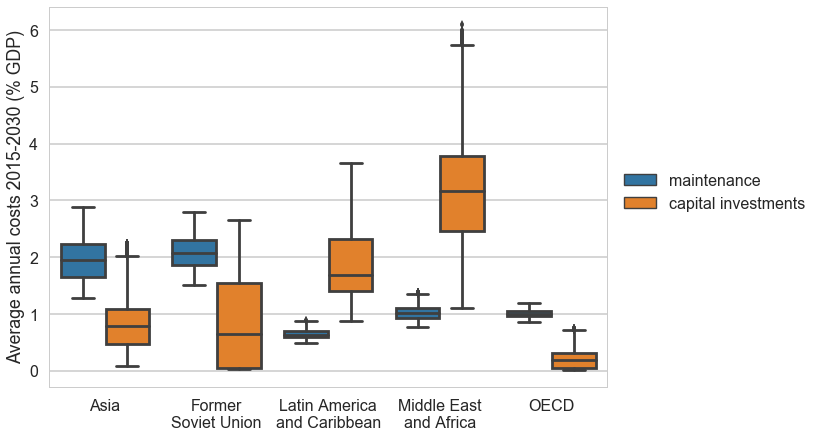

In [72]:
fig2, ax2 = plt.subplots()
sns.boxplot(x="region",y="allmodes",hue="costtype",data=paul.replace({"maint":"maintenance","new":"capital investments"}),ax=ax2)
fig2.set_size_inches(10, 7)
ax2.set_xlabel("")
ax2.set_ylabel("Average annual costs 2015-2030 (% GDP)")
plt.legend(title="",bbox_to_anchor=(1.005, 0.6))
plt.savefig("imaclim_per_region_share_gdp_k_maint.png",ddpi=300,bbox_inches="tight")
plt.savefig("imaclim_per_region_share_gdp_k_maint.pdf")

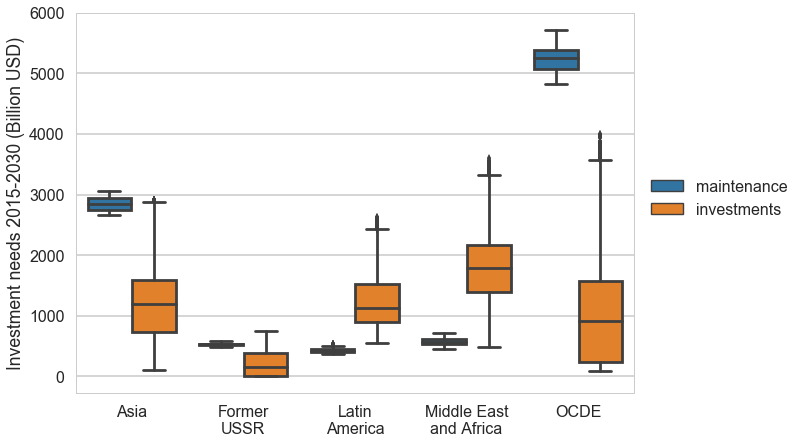

In [353]:
to_plot["costtype"] = to_plot.costtype.replace({"maint":"maintenance","new":"investments"})

fig1, ax1 = plt.subplots()

sns.boxplot(x="region",y="allmodes",hue="costtype",data=to_plot,ax=ax1)
fig1.set_size_inches(10, 7)
ax1.set_xlabel("")
ax1.set_ylabel("Investment needs 2015-2030 (Billion USD)")
plt.legend(title="",bbox_to_anchor=(1.005, 0.6))

plt.savefig("CIRED_total_per_region.png",ddpi=300,bbox_inches="tight")
plt.savefig("CIRED_total_per_region.pdf")

In [396]:
bb = all_data.disc_value.unstack("transpmode")["allmodes"].unstack("region").drop("OCDE",axis=1).sum(axis=1).unstack("costtype")["new"]

In [397]:
forprim = bb.reset_index()

In [398]:
forprim.columns

Index(['combi', 'ind_climat', 'ind_growth', 'ind_mitig', 'ind_trans_A',
       'ind_trans_S', 'ind_trans_I', 'ind_trans_F', 'modal_scenario',
       'ur_ideal', 'urt_ideal', 'delay', 'costs_evolution_road',
       'costs_evolution_rail', 'new'],
      dtype='object')

In [399]:
forprim.new.describe()

count    41472.000000
mean      4471.871979
std       1586.703538
min       1282.288288
25%       3241.739707
50%       4153.483499
75%       5597.622848
max       9608.907676
Name: new, dtype: float64

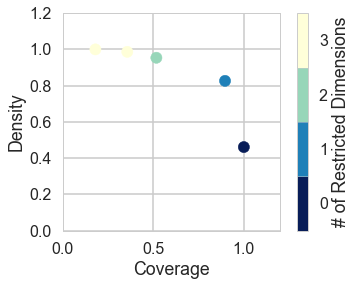

In [452]:
p = prim.Prim(forprim[['ind_climat', 'ind_growth', 'ind_mitig', 'ind_trans_A',
       'ind_trans_S', 'ind_trans_I', 'ind_trans_F', 'modal_scenario',
       'ur_ideal', 'urt_ideal', 'delay', 'costs_evolution_road',
       'costs_evolution_rail']], forprim.new, threshold=4000, threshold_type="<")

box = p.find_box()
box.show_tradeoff();

In [453]:
box.select(1)
print(box.coverage,box.density)
box.limits

0.896135139376 0.82634066358


,min,max,qp values
urt_ideal,30000.0,30000.0,0.0


In [400]:
p = prim.Prim(forprim[['ind_climat', 'ind_growth', 'ind_mitig', 'ind_trans_A',
       'ind_trans_S', 'ind_trans_I', 'ind_trans_F', 'modal_scenario',
       'ur_ideal', 'urt_ideal', 'delay', 'costs_evolution_road',
       'costs_evolution_rail']], forprim.new, threshold=5600, threshold_type=">")

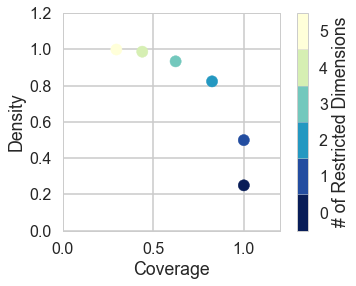

In [401]:
box = p.find_box()
box.show_tradeoff();

In [402]:
box.select(2)
print(box.coverage,box.density)

0.824449594438 0.82349537037


In [403]:
box.limits

,min,max,qp values
urt_ideal,5000.0,5000.0,0.0
modal_scenario,1.0,1.0,0.0


In [385]:
forprim.modal_scenario.unique()

array([0, 1], dtype=int64)

In [367]:
forprim.urt_ideal.unique()

array([ 5000, 30000], dtype=int64)

In [368]:
cc = all_data.disc_value.unstack("transpmode")["allmodes"].unstack("costtype").sum(axis=1).rename(columns={0:"cost"})

In [369]:
forprim2 = cc.unstack("region").reset_index()

In [370]:
forprim2.columns

Index(['combi', 'ind_climat', 'ind_growth', 'ind_mitig', 'ind_trans_A',
       'ind_trans_S', 'ind_trans_I', 'ind_trans_F', 'modal_scenario',
       'ur_ideal', 'urt_ideal', 'delay', 'costs_evolution_road',
       'costs_evolution_rail', 'ASIA', 'CIS', 'LAM', 'MAF', 'OCDE'],
      dtype='object', name='region')

In [371]:
forprim2[["ASIA","LAM","CIS","MAF"]].describe()

region,ASIA,LAM,CIS,MAF
count,41472.000000,41472.000000,41472.000000,41472.000000
mean,4059.402678,1668.853176,740.837149,2378.183960
std,669.686058,440.100474,214.178027,605.442248
min,2758.885645,917.899704,501.781292,933.944643
25%,3547.022867,1316.135161,543.771832,1938.004959
50%,4028.322399,1561.212699,687.614444,2372.061490
75%,4470.024703,1963.117959,923.149275,2773.934465
max,5971.275123,3159.824019,1332.069240,4310.733445


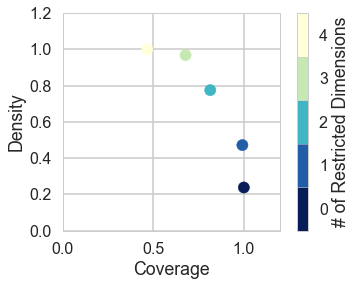

In [372]:
p2 = prim.Prim(forprim2[['ind_climat', 'ind_growth', 'ind_mitig', 'ind_trans_A',
       'ind_trans_S', 'ind_trans_I', 'ind_trans_F', 'modal_scenario',
       'ur_ideal', 'urt_ideal', 'delay', 'costs_evolution_road',
       'costs_evolution_rail']], forprim2.ASIA, threshold=4500, threshold_type=">")

box2 = p2.find_box()
box2.show_tradeoff();

In [373]:
box2.select(2)
print(box2.coverage,box2.density)

0.814552087556 0.775270061728


In [374]:
box2.limits

,min,max,qp values
urt_ideal,5000.0,5000.0,0.0
modal_scenario,1.0,1.0,0.0


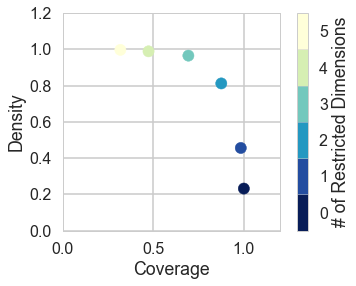

In [375]:
p3 = prim.Prim(forprim2[['ind_climat', 'ind_growth', 'ind_mitig', 'ind_trans_A',
       'ind_trans_S', 'ind_trans_I', 'ind_trans_F', 'modal_scenario',
       'ur_ideal', 'urt_ideal', 'delay', 'costs_evolution_road',
       'costs_evolution_rail']], forprim2.LAM, threshold=2000, threshold_type=">")

box3 = p3.find_box()
box3.show_tradeoff();

In [376]:
box3.select(2)
print(box3.coverage,box3.density)

0.875454828984 0.812210648148


In [377]:
box3.limits

,min,max,qp values
urt_ideal,5000.0,5000.0,0.0
modal_scenario,1.0,1.0,0.0


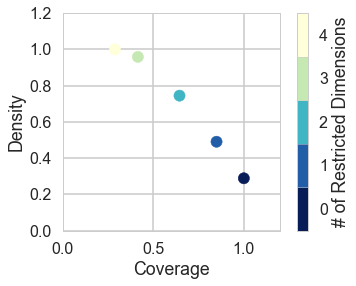

In [378]:
p4 = prim.Prim(forprim2[['ind_climat', 'ind_growth', 'ind_mitig', 'ind_trans_A',
       'ind_trans_S', 'ind_trans_I', 'ind_trans_F', 'modal_scenario',
       'ur_ideal', 'urt_ideal', 'delay', 'costs_evolution_road',
       'costs_evolution_rail']], forprim2.MAF, threshold=2700, threshold_type=">")

box4 = p4.find_box()
box4.show_tradeoff();

In [379]:
box4.select(2)
print(box4.coverage,box4.density)

0.644897277434 0.744791666667


In [380]:
box4.limits

,min,max,qp values
urt_ideal,5000.0,5000.0,0.0
ur_ideal,600.0,600.0,0.0


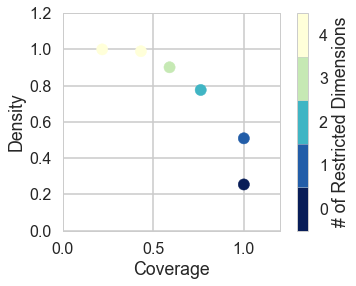

In [381]:
p5 = prim.Prim(forprim2[['ind_climat', 'ind_growth', 'ind_mitig', 'ind_trans_A',
       'ind_trans_S', 'ind_trans_I', 'ind_trans_F', 'modal_scenario',
       'ur_ideal', 'urt_ideal', 'delay', 'costs_evolution_road',
       'costs_evolution_rail']], forprim2.CIS, threshold=920, threshold_type=">")

box5 = p5.find_box()
box5.show_tradeoff();

In [382]:
box5.select(2)
print(box5.coverage,box5.density)

0.761931818182 0.776041666667


In [383]:
box5.limits

,min,max,qp values
delay,35.0,35.0,0.0
urt_ideal,5000.0,5000.0,0.0


In [384]:
forprim.urt_ideal.unique()

array([ 5000, 30000], dtype=int64)

In [456]:
forprim.ur_ideal.unique()

array([600, 900], dtype=int64)